# Tutorial: Informational Design in Optics

This notebook is a tutorialised version of the paper "Differentiable Optics with ∂Lux II: Optical Design Maximizing Fisher Information". It is intended to be a companion piece of code that generates the figures in the paper, and provides a more detailed explanation of the code and methods used.

**Authors**

- Louis Desdoigts
- Benjamin Pope
- Michael Gully-Santiago
- Peter Tuthill

**Abstract**

To design astronomical hardware operating close to the diffraction limit requires optimization of physical optics simulations of the instrument with respect to figures of merit, such as throughput or astrometric accuracy. These systems can be high dimensional, with very nonlinear relationships between outputs and the adjustable parameters of the hardware.
In this series of papers we present and apply [∂Lux](https://github.com/LouisDesdoigts/dLux), an open-source end-to-end differentiable optical modelling framework. Automatic differentiation enables not just efficient high-dimensional optimization of astronomical hardware designs, but also Bayesian experimental design directly targeting the precision of experimental outcomes.
Automatic second derivatives enable the exact and numerically stable calculation of parameter covariance forecasts, and higher derivatives of these enable direct optimization of these forecasts.
We validate this method against analytic theory and illustrate its utility in evaluating the astrometric precision of a parametrized telescope model, and designing a diffractive pupil to achieve optimal astrometric performance for exoplanet searches. The source code and tutorial software are open source and publicly available, targeting researchers who may wish to harness [∂Lux](https://github.com/LouisDesdoigts/dLux) for their own optical simulation problems. 

**Software**

The key piece of code enabling these new methods is [dLux](https://github.com/LouisDesdoigts/dLux) an open-source differentiable optical modelling framework built in Jax. As a new framework, we will try and explain its usage as much as possible.

**Theory**

For information relating to the theory of Fisher Information, please refer to the paper.

In [1]:
# Set CPU count for numpyro multi-chain multi-thread
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=2'

# General Imports
import jax
import jaxlib
import jax.numpy as np
import jax.random as jr
import dLux as dl
import dLux.utils as dlu
import zodiax as zdx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Enable 64bit precision (note this must be run in the first cell of the notebook)
jax.config.update("jax_enable_x64", True)

In [2]:
# Check versions
print("Jax version:", jax.__version__)
print("Jaxlib version:", jaxlib.__version__)
print("dLux version:", dl.__version__)
print("zodiax version:", zdx.__version__)

Jax version: 0.4.24
Jaxlib version: 0.4.24
dLux version: 0.14.0
zodiax version: 0.4.1


Install and import a specific version of chainconsumer, it was updated right before submission with some bugs that broke the plotting!

In [3]:
!pip install ChainConsumer==0.33.0
import chainconsumer as cc

/Users/louis/mambaforge/envs/testing/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
# Set global plotting parameters
%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 300

## Validation against Analytical Solutions

A monochromatic point source observed through a clear aperture gives a perfect Airy Disk psf. From this a closed form solution can be derived relating the number of photons detected to the uncertainty in the position of the source. This is a good test of our numerical methods.

$$\sigma_{r} = \frac{1}{\pi} \sqrt{\frac{2}{\text{Nphot}}}  \frac{\lambda}{D} \ (\text{radians})$$

We want to compare these values output by this equation to the values output by our numerical methods.

**How do we do this in dLux?**

dLux is designed to be a very flexible framework which is quite beneficial in our case as we can rapidly create a simple model to work with that has whatever parameters with whatever units we desire. In this case we will make a simple source object with (x, y) position in arcseconds, flux in photons, and wavelength in microns. 

To do this we can create a class that inherits from the `source.BaseSource` class, then our object will be able to be used in the rest of the dLux framework. This requires us to create three methods, `__init__`, `normalise` and `model`. Note that dLux is build in Zodiax which is permits object-oriented Jax, as such there are some slight differences in how to work with these object, given their immutable nature. We will address most of these as we go, but this is designed to be a tutorial showing the cool things you can do with autodiff, not a 'ground-up' tutorial, those can be found in the [∂Lux Docs](https://louisdesdoigts.github.io/dLux/tutorials/introductory/overview/).

In [5]:
# Construct a simple Source object, with the desired units (positions in arcseconds,
# flux in photons, and wavelengths in microns).
class Source(dl.sources.BaseSource):
    """Simple dLux Source object class.
    Note in the Equinox/Zodiax framework we must declare attributes like this 
    and must populate them in the constructor!
    """
    x : float           # arcseconds
    y : float           # arcseconds
    flux : float        # photons
    wavelengths : float # microns

    def __init__(self, wavelengths=1., x=0., y=0., flux=1.):
        """Constructor for the Source class."""
        self.x = x
        self.y = y
        self.flux = flux
        self.wavelengths = wavelengths
    
    def normalise(self):
        """Normalisation method, not required for this example."""
        return self

    def model(self, optics, return_wf=False, return_psf=False):
        """Modelling method. Propagates the source through the optical system,
        while also scaling the class parameter to the appropriate units."""
        position = dlu.arcsec2rad(np.array([self.x, self.y]))
        wf = optics.propagate(self.wavelengths * 1e-6, position, return_wf=True)
        wf = wf.multiply('amplitude', self.flux**0.5)

        # Return wf case
        if return_wf:
            return wf

        # Return psf case
        if return_psf:
            return dl.PSF(wf.psf.sum(0), wf.pixel_scale.mean())
        
        # Return array case
        return wf.psf.sum(0)

Now we construct our source object, a simple optical system with a 1m diameter aperture with a pixel scale of 0.1 arcseconds, with a 4x oversample and combine them into an Instrument object that we will work with.

In [6]:
# Construct the source object
source = Source()

# Define wavefront properties
wf_npixels = 256
diameter = 1

# Construct a circular Aperture
coords = dlu.pixel_coords(wf_npixels, diameter)
circ = dlu.circle(coords, diameter/2)

# Detector parameters
psf_npixels = 50
psf_pixel_scale = 25e-3 # 25 mas

# Construct optical system
optics = dl.AngularOpticalSystem(
    diameter=1, 
    wf_npixels=wf_npixels, 
    layers = [('aperture', dl.TransmissiveLayer(circ, normalise=True))],
    psf_npixels=psf_npixels, 
    psf_pixel_scale=psf_pixel_scale)

# Combine these into a instrument object and print it to have a look
telescope = dl.Telescope(optics, source)
print(telescope)

Telescope(
  optics=AngularOpticalSystem(
    wf_npixels=256,
    diameter=1.0,
    layers={
      'aperture':
      TransmissiveLayer(transmission=f64[256,256], normalise=True)
    },
    psf_npixels=50,
    oversample=1,
    psf_pixel_scale=0.025
  ),
  source=Source(x=0.0, y=0.0, flux=1.0, wavelengths=1.0),
  detector=None
)


Now we can calculate both our analytic and numerical solutions for the flux and position uncertainties in order to see how they compare

In [7]:
# Define flux range
fluxes = 10**np.arange(2, 9).astype(float)

# Define our likelihood function and bind it to our covariance function
# We use poissonian here because we are assuming photon noise is our dominant noise source
calc_cov = lambda model, parameters: zdx.self_covariance_matrix(model, parameters, zdx.poiss_loglike)

# Iterate over fluxes and calculate the values
sigma_flux_calc = []
sigma_r_calc = []
for flux in tqdm(fluxes):
    
    # Update the source flux using Zodiax syntax
    telescope = telescope.set('source.flux', float(flux))

    # Calculate the flux covariance
    cov = calc_cov(telescope, 'source.flux')
    sigma_flux_calc.append(np.squeeze(cov)**0.5)

    # Calculate the position covariance
    cov = calc_cov(telescope, ['source.x', 'source.y'])
    sigma_r_calc.append(np.diag(cov).sum()**0.5)

sigma_r_calc = np.array(sigma_r_calc)

# Calculate the theoretical values
lamd = 1e-6 * source.wavelengths / optics.diameter
sigma_flux_analytic = fluxes ** 0.5
sigma_r_analytic = dlu.rad2arcsec(1 / np.pi * np.sqrt(2 / fluxes) * lamd)

  0%|          | 0/7 [00:00<?, ?it/s]

We now also replicate these results using a MCMC sampler to use as our ground truth.

In [8]:
# PPL
import numpyro as npy
import numpyro.distributions as dist

parameters = ['source.x', 'source.y']

# Set up our modelling function for numpyro
def psf_model(data_in, model_in):
    """Define the numpyro sampling function"""

    values = [
        npy.sample("x", dist.Uniform(-.5, .5)),
        npy.sample("y", dist.Uniform(-.5, .5))
    ]

    with npy.plate("data", len(data_in.flatten())):
        poisson_model = dist.Poisson(
            model_in.set(parameters, values).model().flatten())
        return npy.sample("psf", poisson_model, obs=data_in.flatten())

Run the chains for a few thousand steps and then plot the results.

In [9]:
from jax import device_count

chains = []
samplers = []
datas = []
for i in range(len(fluxes)):

    sampler = npy.infer.MCMC(
        npy.infer.NUTS(psf_model, init_strategy=npy.infer.init_to_value(values={'x': np.array(0.), 'y': np.array(0.)})),
        num_warmup=1000,
        num_samples=1000,
        num_chains=device_count(),
        progress_bar=True,
    )

    # Update the source flux using Zodiax syntax
    model = telescope.set('source.flux', fluxes[i])
    data = model.model()
    datas.append(data)

    sampler.run(jr.PRNGKey(0), data, model)
    samples = sampler.get_samples()
    samplers.append(sampler.get_samples())
    chains.append(np.array([samples['x'], samples['y']]))
chains = np.array(chains)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

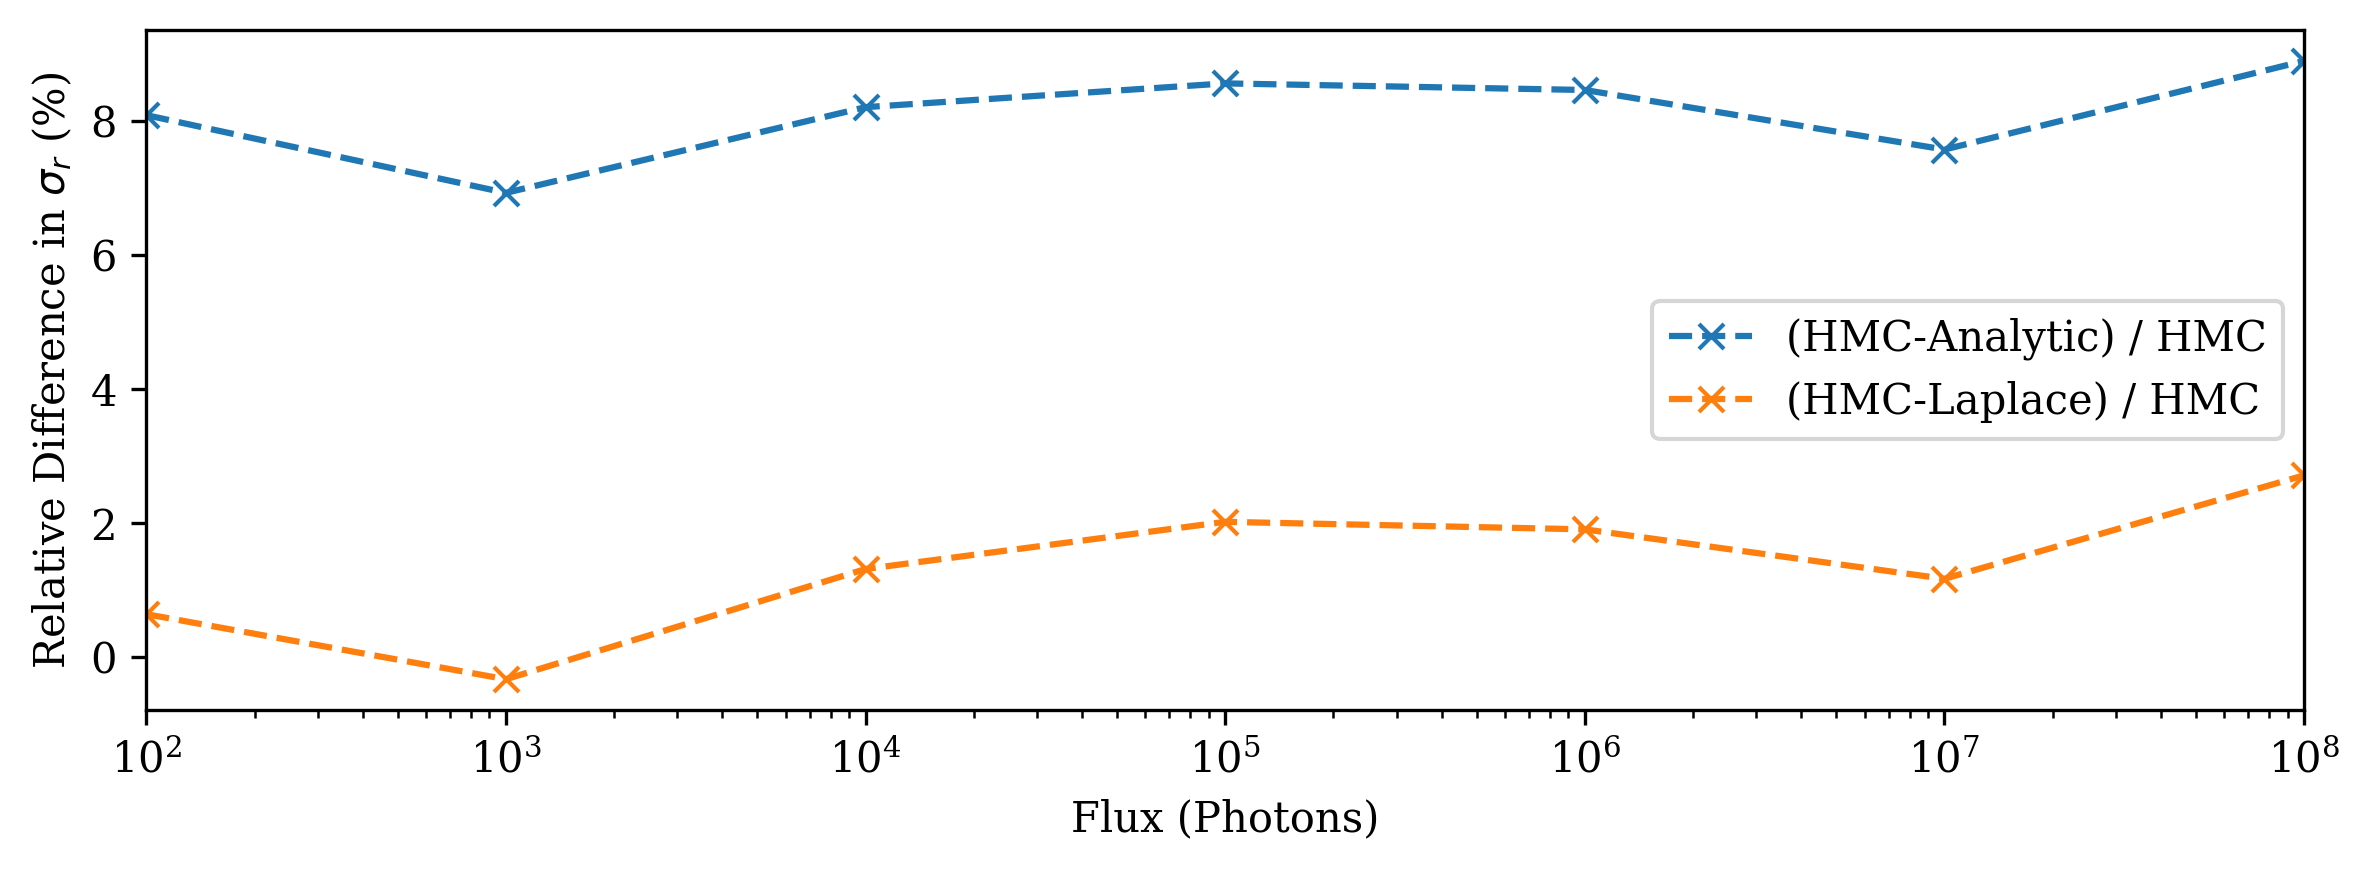

In [10]:
x_std = np.std(chains[:, 0], axis=-1)
y_std = np.std(chains[:, 1], axis=-1)
HMC_std = np.hypot(x_std, y_std)


fig, ax = plt.subplots(1, 1, figsize=(8, 3), sharex=True)

ax.plot(fluxes, 100*(HMC_std - sigma_r_analytic)/HMC_std, marker='x', linestyle='--', label='(HMC-Analytic) / HMC')
ax.plot(fluxes, 100*(HMC_std - sigma_r_calc)/HMC_std, marker='x', linestyle='--', label='(HMC-Laplace) / HMC')
ax.set_xlim(fluxes.min(), fluxes.max())
ax.legend()
ax.semilogx()

ax.set_xlabel("Flux (Photons)")
ax.set_ylabel(r"Relative Difference in $\sigma_{r}$ (%)")

plt.tight_layout()
plt.savefig("figures/theory_comparison.pdf", bbox_inches='tight', dpi=300)
plt.show()

Excellent, we can see that our numerical methods is actually a _better_ match to the MCMC sampler than the analytic solution. This is because the analytic solution assumes an infinite image plane, which is clearly not possible. The numerical solution and the HMC are calculated directly on the forwards model and so do not have this limitation!

---

## Asymmetric Pupil Wavefront Sensor

### NOTE: This section has been removed from the paper, but serves to demonstrate other uses of Fisher information methods enabled by dLux

In this section we dive deeper and look at how we can examine more complex relationships between parameters, and analyse performance of a system parametrised by an arbitrary component. The particular problem we will tackle is the sign ambiguity of odd zernike aberrations in symmetric apertures, addressed for the SCExAO system in [Martinache 2016](https://ui.adsabs.harvard.edu/abs/2016A&A...593A..33M/abstract). Without going into detail, we need to add an asymmetry to our telescope pupil in order to be able to correctly sense the optical aberrations in the system. In
[Martinache 2016](https://ui.adsabs.harvard.edu/abs/2016A&A...593A..33M/abstract) they provide a solution, but do not quantify that solution against the overall performance of the system. We will do that here.

First, lets create an optical system that matches the SCExAO system!

In [11]:
# Define the parameters
diameter = 8.2 # meters
wf_npixels = 256

# Get the SCExAO transmission
SCExAO_transmission = np.load('data/subaru.npy')

# Generate a zernike basis
coords = dlu.pixel_coords(wf_npixels, diameter)
zernikes = 1e-9 * dlu.zernike_basis([4, 5, 6, 7, 8, 9, 10], coords, diameter)

# Construct the aperture
aperture = dl.BasisOptic(transmission=SCExAO_transmission, basis=zernikes, normalise=True)

# Add asymmetric mask
tf = dl.CoordTransform(translation=[-diameter/4, -0.1], rotation=-0.15)
mask = dl.RectangularAperture(1., diameter/2, tf, occulting=True, softening=1)

# Construct the optics class
optics = dl.AngularOpticalSystem(
    wf_npixels=wf_npixels, 
    diameter=diameter, 
    layers = [('aperture', aperture), ('mask', mask)],
    psf_npixels=256, 
    psf_pixel_scale=.0121 / 2,
)

# Source
wavelengths = np.linspace(1.5, 1.8, 10)
source = Source(wavelengths, flux=1e6)

# Construct the Instrument class and print it
telescope = dl.Telescope(optics, source)
print(telescope)

Telescope(
  optics=AngularOpticalSystem(
    wf_npixels=256,
    diameter=8.2,
    layers={
      'aperture':
      BasisOptic(
        basis=f64[7,256,256],
        coefficients=f64[7],
        as_phase=False,
        transmission=f64[256,256],
        normalise=True
      ),
      'mask':
      RectangularAperture(
        normalise=False,
        transformation=CoordTransform(
          translation=f64[2],
          rotation=f64[],
          compression=None,
          shear=None
        ),
        occulting=True,
        softness=1.0,
        height=1.0,
        width=4.1
      )
    },
    psf_npixels=256,
    oversample=1,
    psf_pixel_scale=0.00605
  ),
  source=Source(x=0.0, y=0.0, flux=1000000.0, wavelengths=f64[10]),
  detector=None
)


Now we want to calculate the covariance matrix of the model, marginalised over the optical aberrations and source position and flux, over a range of asymmetric bar widths. This lets us calculate the relative entropy of each bar width, which can be used to find the value of _maximum information_ for the system.

In [12]:
from jax import vmap

# Marginal params
params = ['x', 'y', 'flux', 'aperture.coefficients']

# Define our likelihood function and bind it to our covariance function
# We use poissonian here because we are assuming photon noise is our dominant noise source
calc_cov = lambda model, parameters: zdx.self_covariance_matrix(model, parameters, zdx.poiss_loglike)

# Bar sizes
widths = np.linspace(0., 3, 26)
covs, rs, fluxes, odds, evens = [], [], [], [], []
for width in tqdm(widths):

    # Set mask width
    model = telescope.set("mask.height", width)

    # Calculate covariance matrix and standard deviations
    cov = calc_cov(model, params)
    stds = np.sqrt(np.diag(np.abs(cov)))

    # Save values
    covs.append(cov)
    rs.append(np.hypot(stds[0], stds[1]))
    fluxes.append(stds[2])
    evens.append(stds[3:6])
    odds.append(stds[6:])

rs = np.array(rs)
fluxes = np.array(fluxes)
odds = np.array(odds)
evens = np.array(evens)
covs = np.array(covs)
ents = vmap(zdx.covaraince_entropy)(covs)

  0%|          | 0/26 [00:00<?, ?it/s]

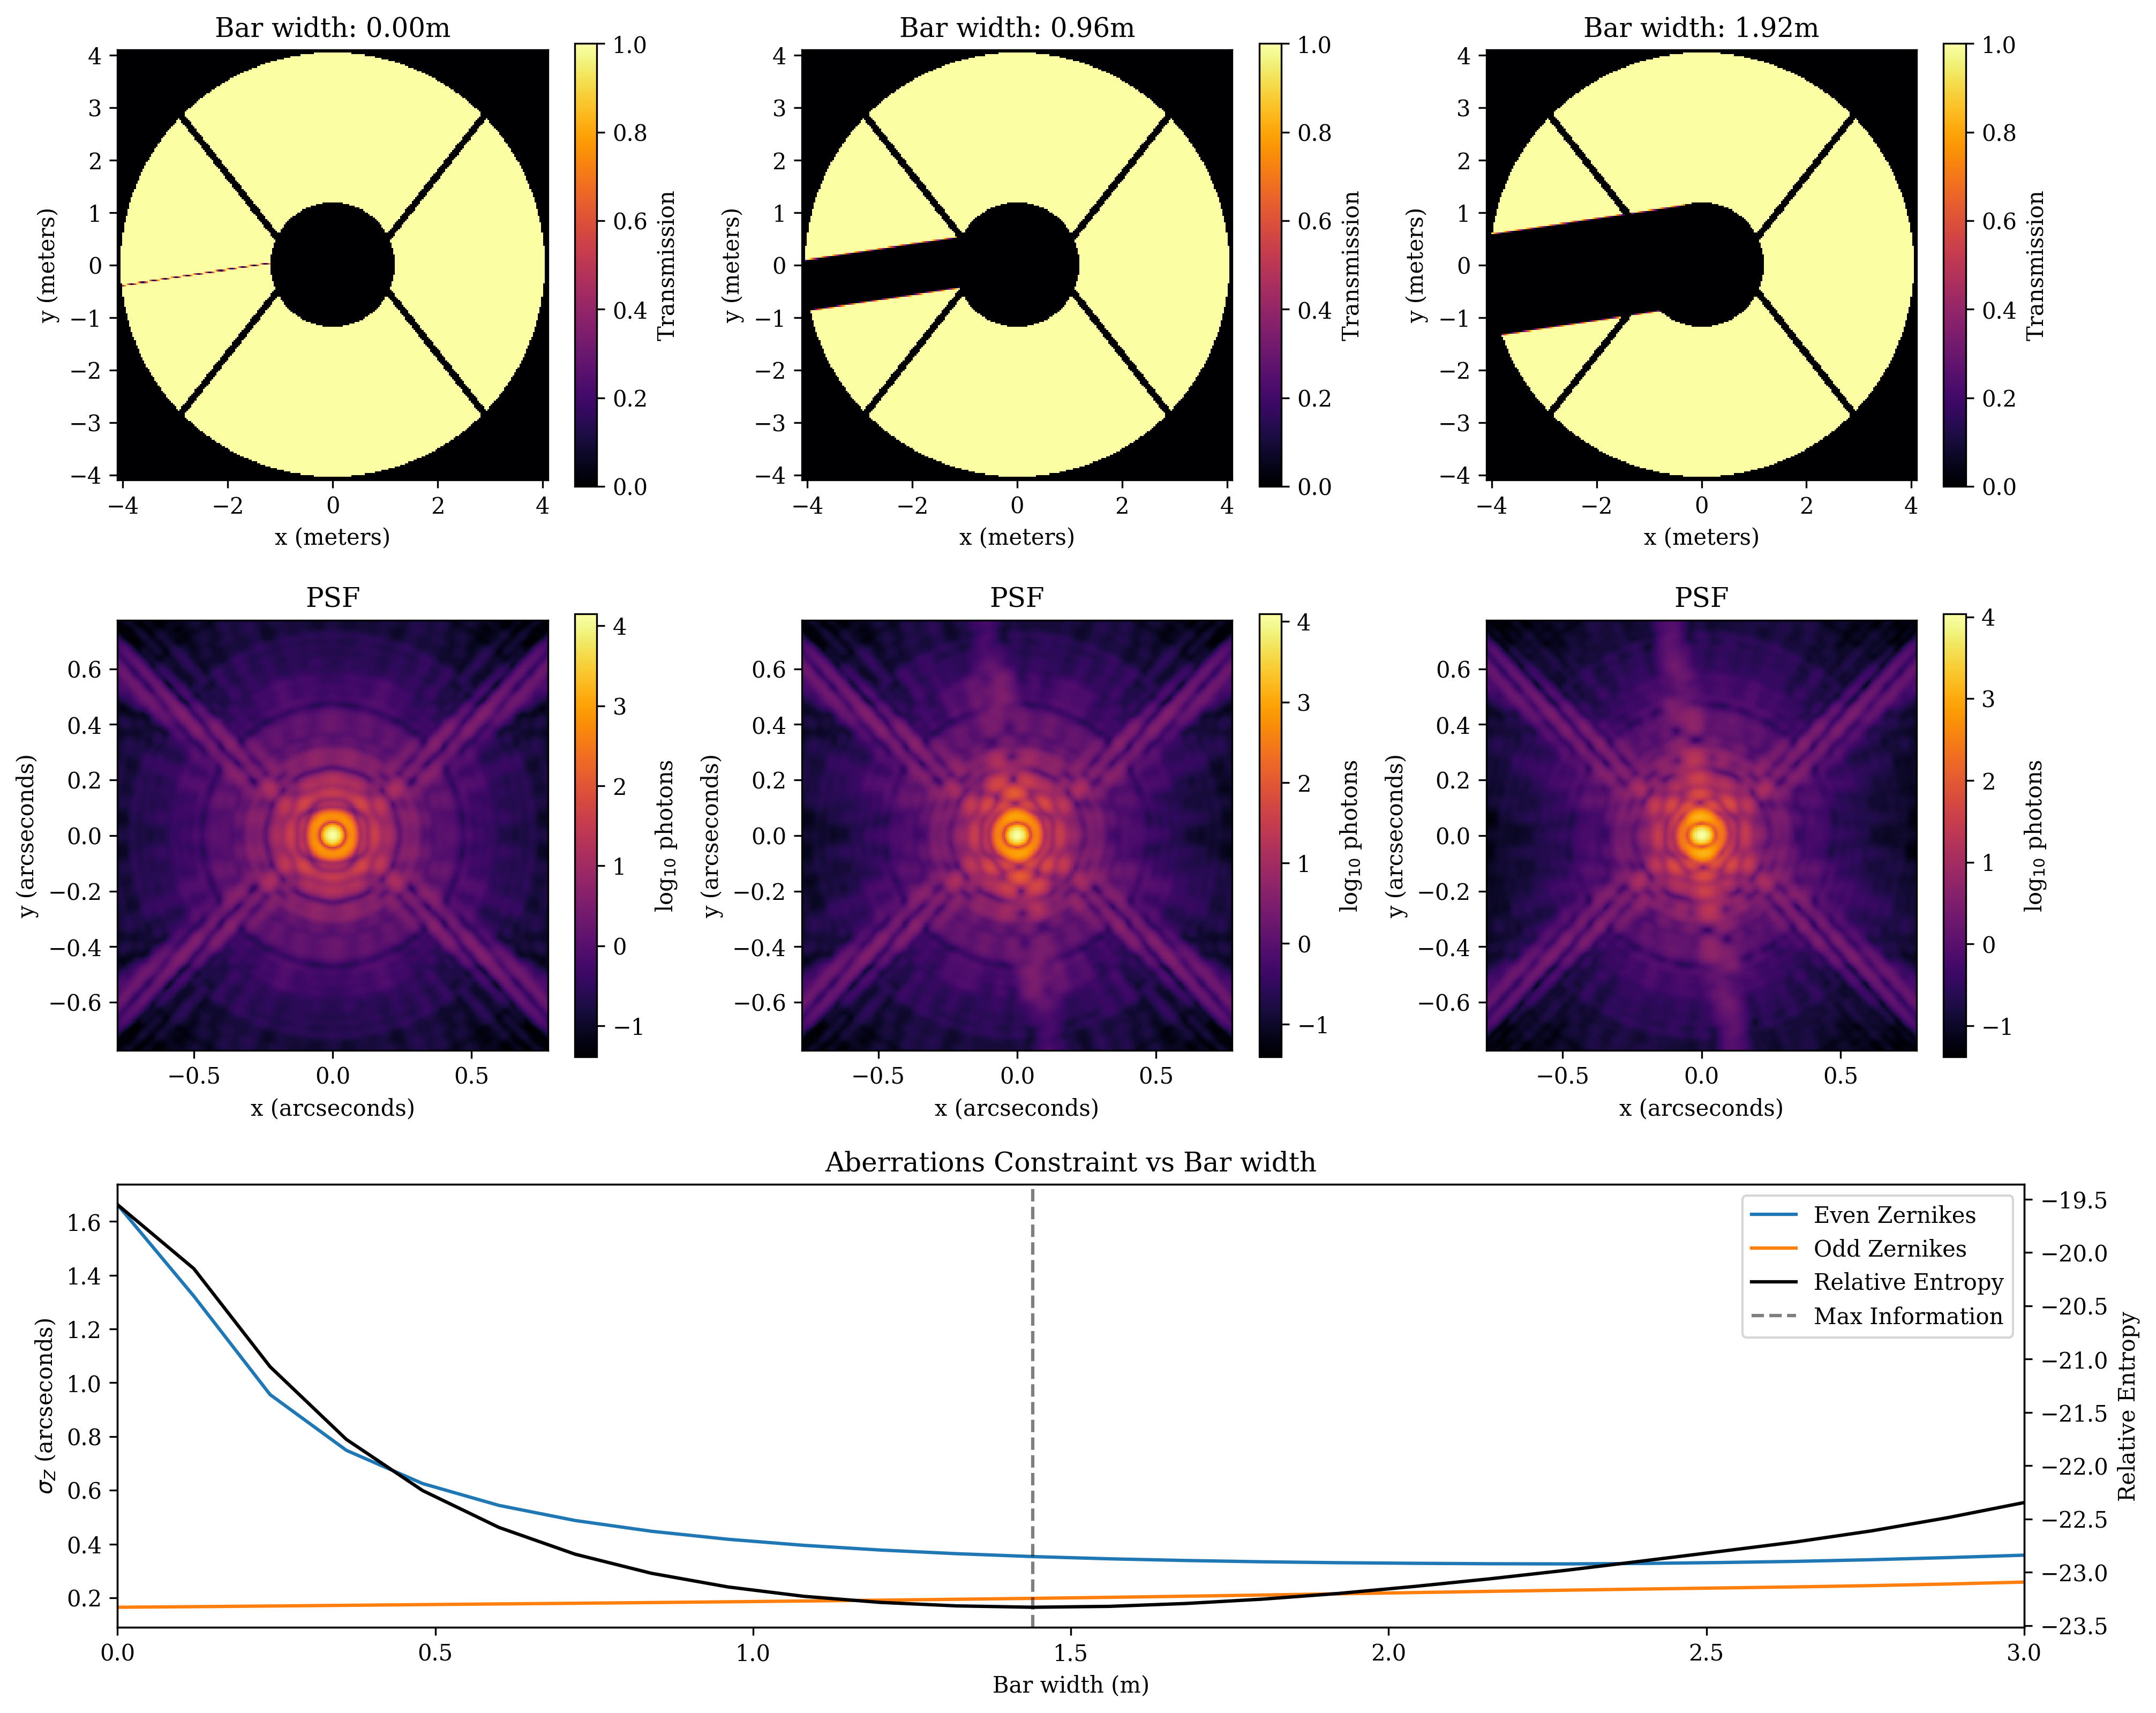

In [13]:
# Calculate values for plotting
apertures, psfs, model_widths = [], [], []
for width in widths[0::8]:

    # Get aperture and PSF
    model = telescope.set('mask.height', width)
    mask_transmission = model.mask.transmission(coords, diameter/wf_npixels)
    aperture_transmission = model.aperture.transmission

    # Save values
    apertures.append(aperture_transmission * mask_transmission)
    psfs.append(model.model())
    model_widths.append(width)

# Maximal Information
min_idx = np.where(ents == np.min(ents))[0]

# Plot Extents
aperture_extent = [-diameter/2, diameter/2, -diameter/2, diameter/2]
fov = telescope.psf_npixels * telescope.psf_pixel_scale
psf_extent = [-fov/2, fov/2, -fov/2, fov/2]

# Zernike Names
odd_names = ["Defoc", "AstigX", "AstigY"]
even_name = ["ComaX", "ComaY", "TfoilX", "TfoilY"]

# Plotting
mosaic = """
         AACCEE
         AACCEE
         BBDDFF
         BBDDFF
         GGGGGG
         GGGGGG
         """

s = 0.9
fig = plt.figure(figsize=(15*s, 12*s))
axes = fig.subplot_mosaic(mosaic)

# Aperture Plots
for i, ax in enumerate(['A', 'C', 'E']):
    axes[ax].set_title(f"Bar width: {model_widths[i]:.2f}m")
    axes[ax].set_xlabel("x (meters)")
    axes[ax].set_ylabel("y (meters)")
    im = axes[ax].imshow(apertures[i], extent=aperture_extent)
    fig.colorbar(im, ax=axes[ax], label="Transmission")

# PSF Plots
for i, ax in enumerate(['B', 'D', 'F']):
    axes[ax].set_title("PSF")
    axes[ax].set_xlabel("x (arcseconds)")
    axes[ax].set_ylabel("y (arcseconds)")
    im = axes[ax].imshow(np.log10(psfs[i]), extent=psf_extent)
    fig.colorbar(im, ax=axes[ax], label=r"log$_{10}$ photons")
    
# Reconfigure values for relative sigma
mean_odds = odds.mean(1)
mean_evens = evens.mean(1)

# Zernikes
axes['G'].set_title("Aberrations Constraint vs Bar width")
axes['G'].set_xlabel("Bar width (m)")
axes['G'].set_ylabel(r"$\sigma_Z$ (arcseconds)")
axes['G'].plot(widths, mean_evens, label='Even Zernikes')
axes['G'].plot(widths, mean_odds, label='Odd Zernikes')
axes['G'].set_xlim(widths.min(), widths.max())

# Entropy
axes['G'].plot([], [], c='k', label="Relative Entropy")
axes['G'].axvline(x=widths[min_idx], color='k', linestyle='--', label="Max Information", alpha=0.5)
axes['G'].legend()
ax2 = axes['G'].twinx()
ax2.plot(widths, ents, c='k', label="Relative Entropy")
ax2.set_ylabel("Relative Entropy")

fig.tight_layout()
fig.savefig('figures/scexao.pdf', dpi=300, bbox_inches='tight')

---

# Informational Optimisation

Awesome, as we can see we have massively improved the performance of odd-term recover, without really sacrificing the performance of the even terms.

Lets see how we can use these tools to solve a real-world problem, namely design of the Toliman diffractive pupil mask. Toliman is a small telescope mission designed to register the minute tugs of a rocky exoplanet on the binary star system AlphaCentauri. For reasons not relevant here we require the mask to binary values, so we will use the [CLIMB algorithm (sec 3.2.2)](https://arxiv.org/abs/2107.00952) in order to meet this constraint. Beyond this, we want to minimise the binary separation variance marginalised over the rest of the optical parameters.

In this system, we care about the following astrophysical parameters:
- Separation
- Position angle
- (x, y) position
- Flux
- Contrast
- Mean Wavelength

and the following optical parameters:
- Optical aberrations
- Pixel scale

Lets see how we can do this, using the [dLuxToliman](https://github.com/maxecharles/dLuxToliman) repo since it has some nice pre-built classes with the CLIMB algorithm and the correct optical parameters for Toliman.

In [14]:
import optax
import dLuxToliman as dlt
print("dLuxToliman version:", dlt.__version__)

# Colormap with grey nans
from matplotlib import colormaps
cmap = colormaps['inferno']
cmap.set_bad('k', .5)

dLuxToliman version: 0.3.0


In [15]:
import dLuxToliman as dlt

# Source
source = dlt.AlphaCen(n_wavels=5)

# Mask
basis = np.load('data/basis.npy')
coefficients = jr.normal(jr.PRNGKey(0), (len(basis),))
mask = dlt.ApplyBasisCLIMB(basis, source.wavelengths.mean()*1e-9, coefficients)

# Optics
radial_orders = [2, 3]
optics = dlt.TolimanOpticalSystem(mask=mask, radial_orders=radial_orders, psf_pixel_scale=0.375/2, oversample=1)
optics = optics.divide('aperture.basis', 1e9) # Set basis units to nanometers

# Instrument
tel = dl.Telescope(optics, source)

Lets take a quick look at the Pupil and PSF

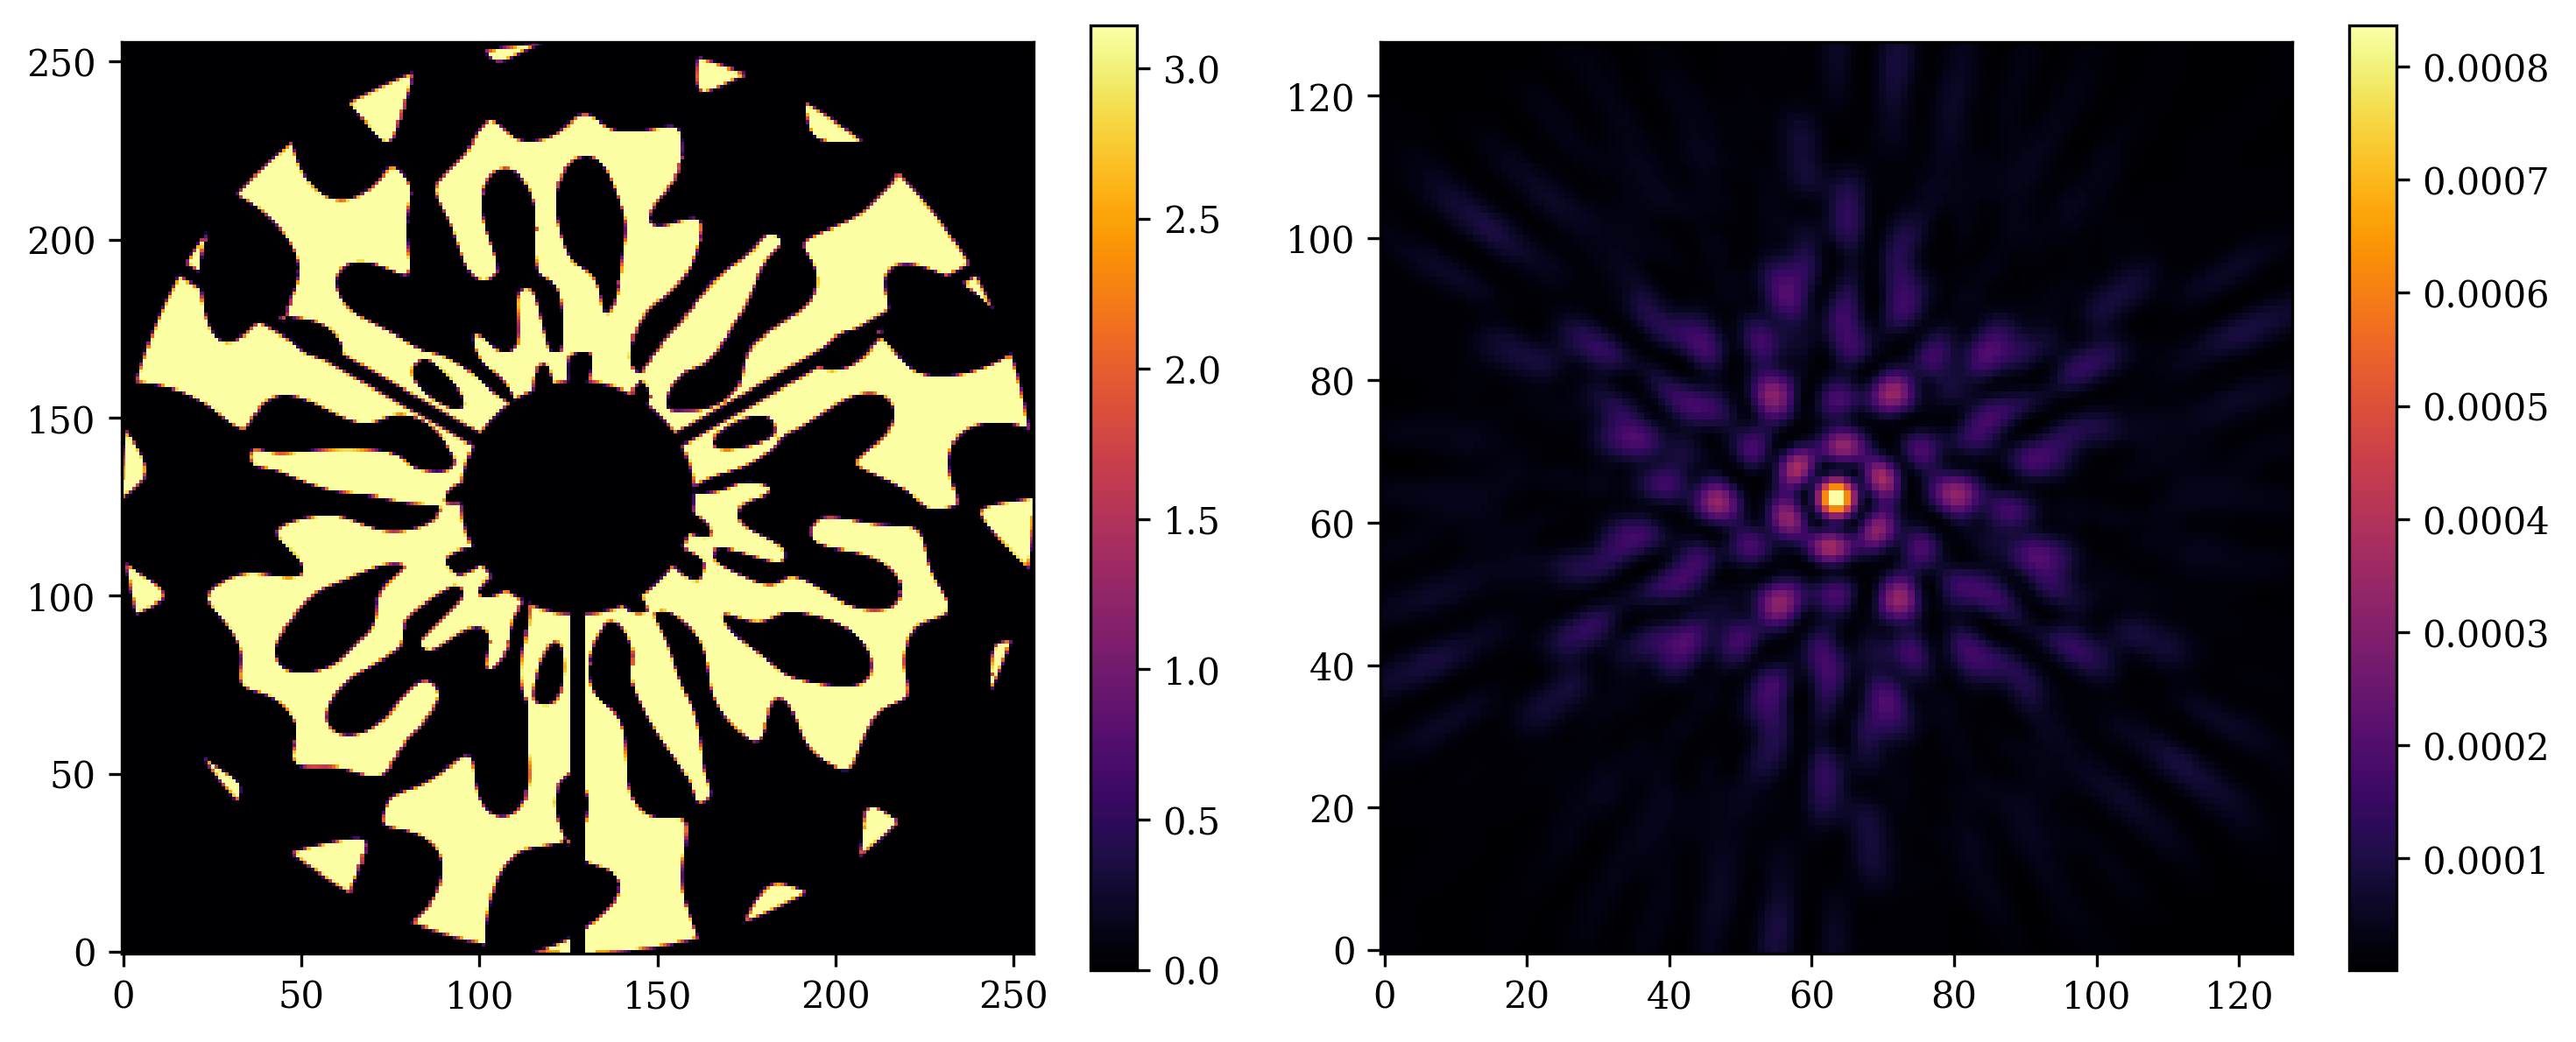

In [16]:
opd_mask = tel.pupil.get_binary_phase() * tel.aperture.transmission
psf = tel.propagate(tel.source.wavelengths*1e-9)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(opd_mask)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(psf)
plt.colorbar()

plt.tight_layout()
plt.show()

### Loss function and optimisation strategy

Now we define our loss function as the standard deviation of the binary separation, and optimise it using the Adam optimiser. We simply minimise the binary separation component of the covariance matrix, marginalised over the rest of the optical parameters.

**Q: What is the shape_dict?**

Since we only care about the _mean_ wavelength of the model, not each individual wavelength we can use the `shape_dict` to force the shape of the perturbing parameter to be a scalar, resulting in the model constraining the _mean_ value of the wavelengths array. This is a very useful trick to know about! 

In [17]:
marginal_params = [
    'separation',
    'position_angle',
    'x_position',
    'y_position',
    'log_flux',
    'contrast',
    'psf_pixel_scale',
    'wavelengths',
    'aperture.coefficients']

shape_dict = {'wavelengths': 1}

# Generate a loss function
@zdx.filter_jit
@zdx.filter_value_and_grad('pupil.coefficients')
def loss_fn(model):
    cov = zdx.self_covariance_matrix(model, marginal_params, zdx.poiss_loglike, shape_dict=shape_dict)
    return np.sqrt(cov[0, 0])

In [18]:
%%time

# Compile the loss function
loss, grads = loss_fn(tel)
print(f"Initial Loss: {loss*1e3:.3f} milli-arcsec")

Initial Loss: 3.817 milli-arcsec
CPU times: user 22.3 s, sys: 1.1 s, total: 23.4 s
Wall time: 11.5 s


In [19]:
# Optimise the model
model = tel
optim, opt_state = zdx.get_optimiser(model, 'pupil.coefficients', optax.adam(5e-1))

losses, models_out = [], []
with tqdm(range(25), desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(model)
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)
        models_out.append(model)
        losses.append(loss)

        t.set_description(f"Loss: {loss*1e3:.3f} milli-arcsec") # update the progress bar
print(f"Final Loss: {loss} arcseconds")

Gradient Descent:   0%|          | 0/25 [00:00<?, ?it/s]

Final Loss: 0.0027071837434738933 arcseconds


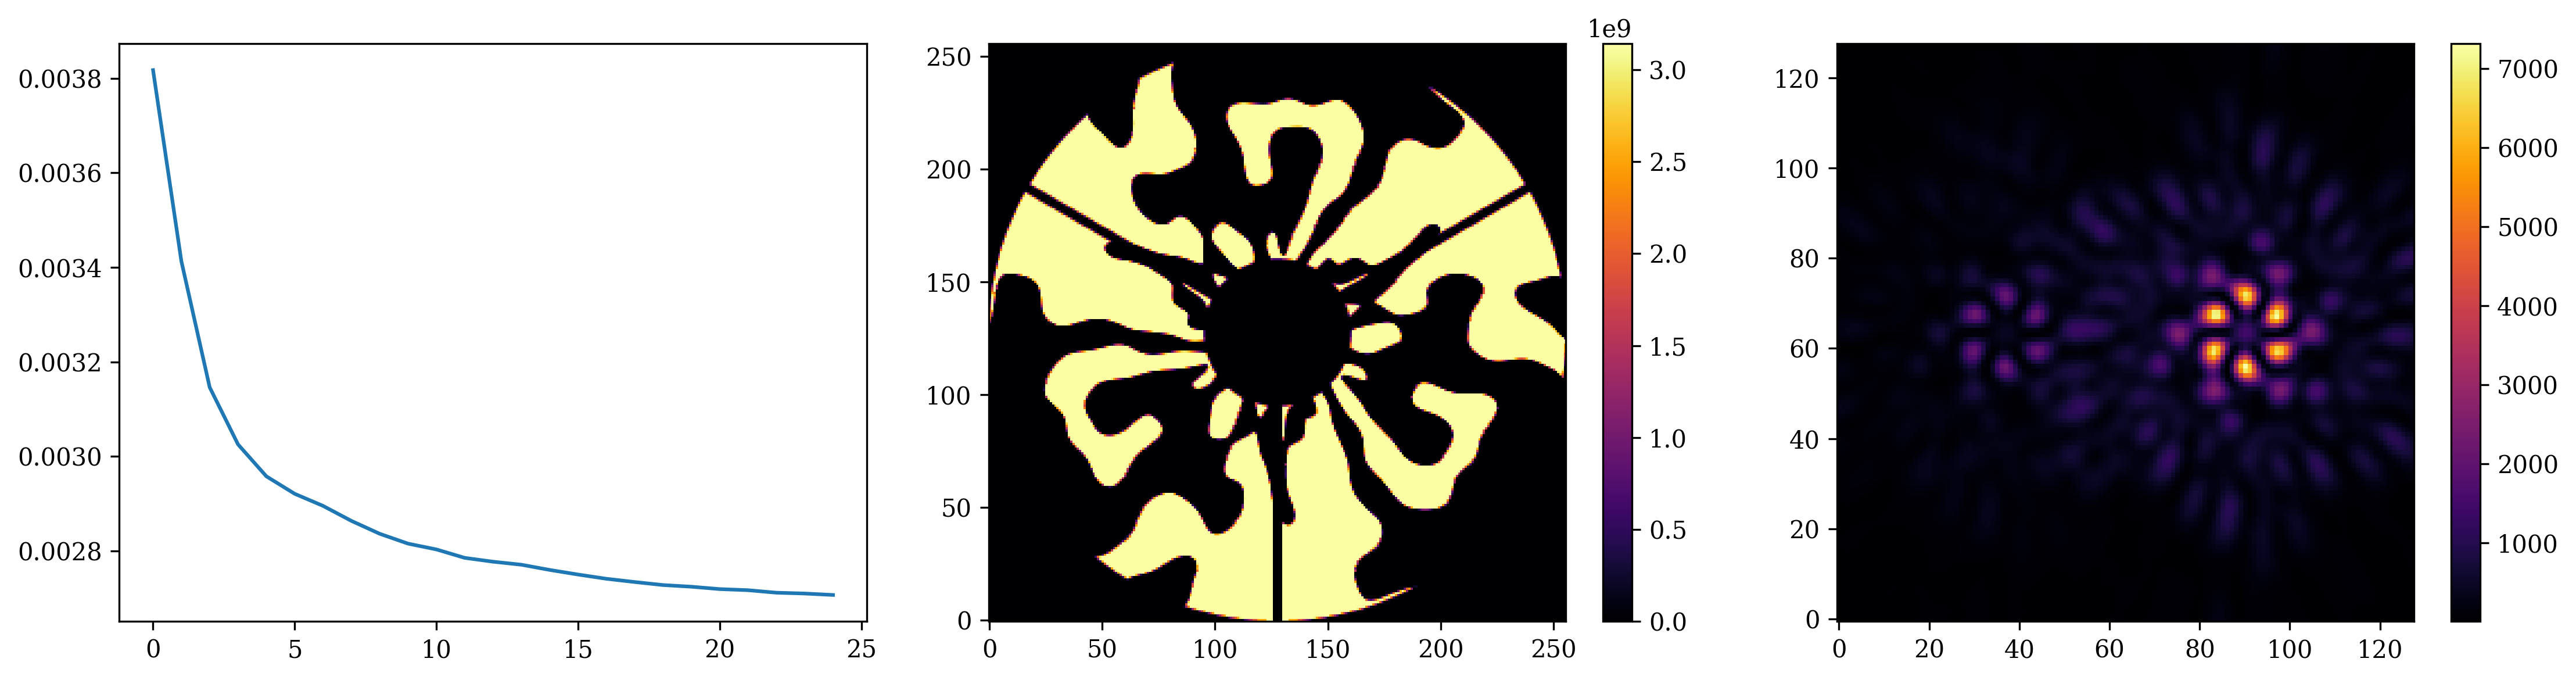

In [20]:
opd_mask = model.pupil.get_binary_phase() * model.aperture.transmission
psf = model.model()

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.plot(losses)

plt.subplot(132)
plt.imshow(opd_mask * 1e9)
plt.colorbar()

plt.subplot(133)
plt.imshow(psf)
plt.colorbar()
plt.tight_layout()
plt.show()

Now lets look at and analyse the difference between the initial and final masks.

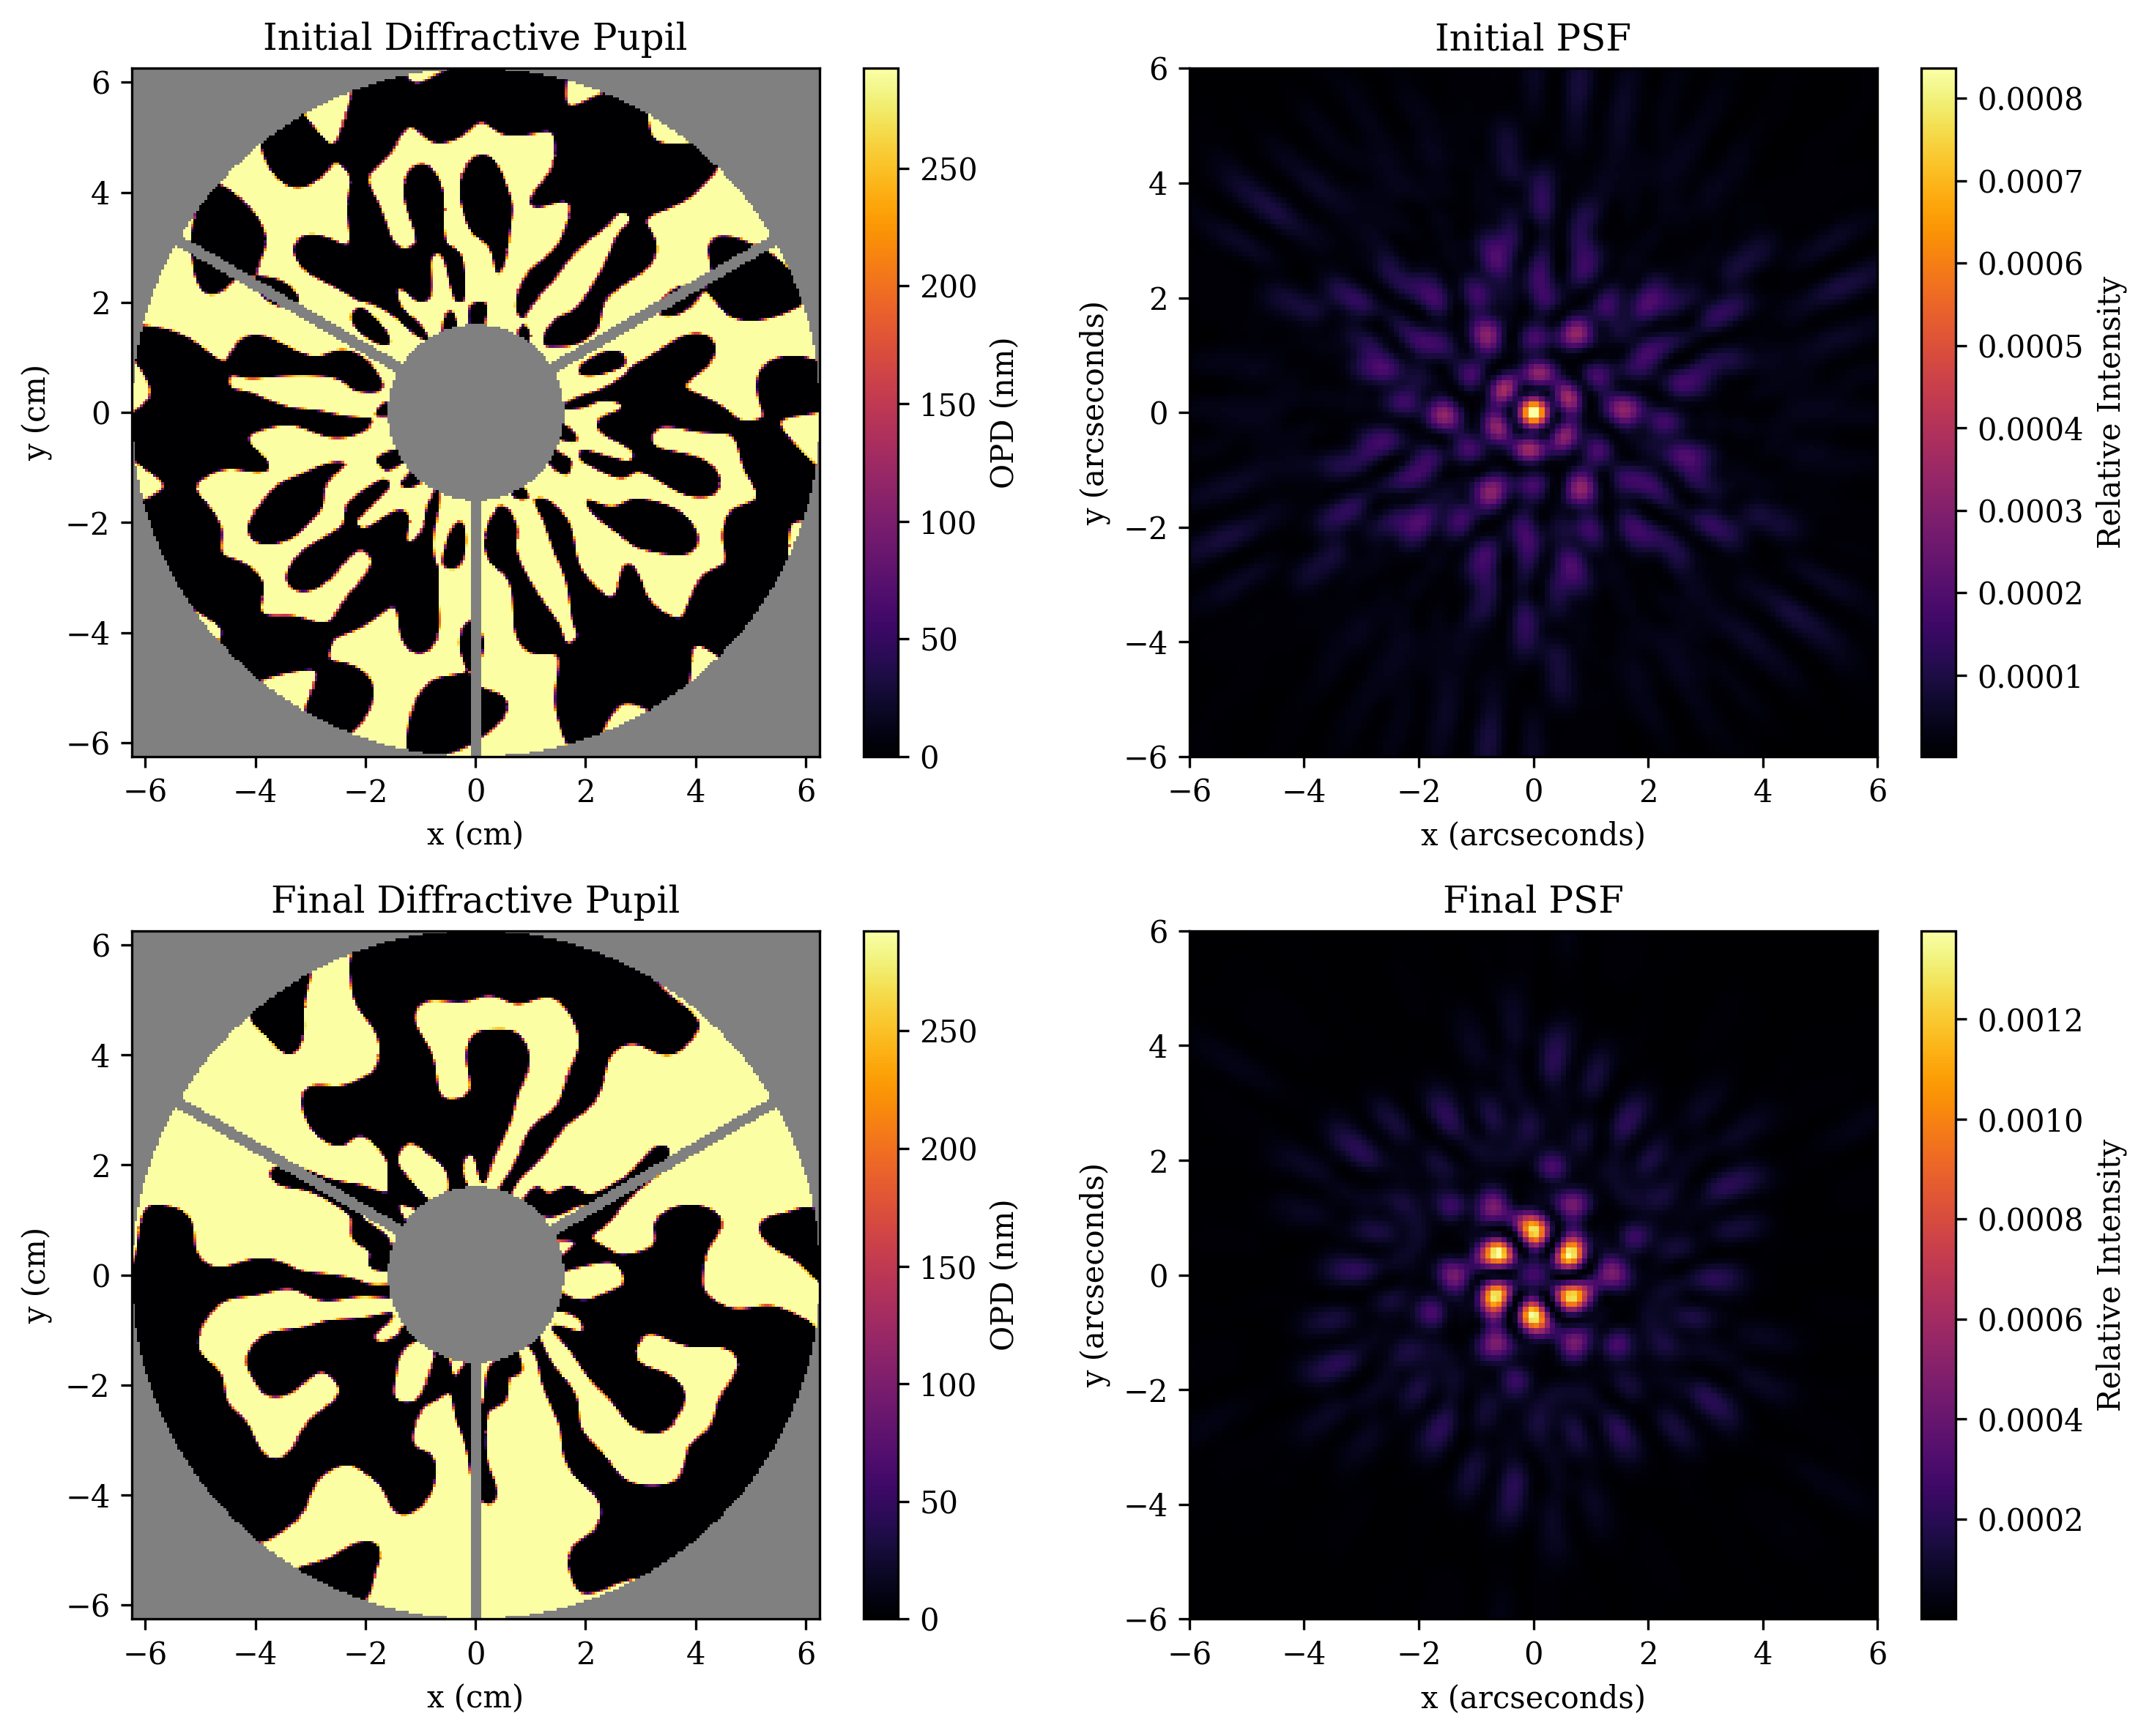

In [21]:
# Get Masks
mean_wl = source.wavelengths.mean()
support = tel.aperture.transmission
initial_mask = tel.pupil.get_binary_phase().at[support <= 0.5].set(np.nan)
final_mask = model.pupil.get_binary_phase().at[support <= 0.5].set(np.nan)

# Get psfs
wavelengths = source.wavelengths * 1e-9
initial_psf = tel.propagate(wavelengths)
final_psf = model.propagate(wavelengths)

# Crop psfs
c, s = initial_psf.shape[0] // 2, 64
initial_psf = initial_psf[c-s:c+s, c-s:c+s]
final_psf = final_psf[c-s:c+s, c-s:c+s]

diam_cm = tel.diameter * 100
aperture_extent = [-diam_cm/2, diam_cm/2, -diam_cm/2, diam_cm/2]
fov = s * tel.optics.psf_pixel_scale
psf_extent = [-fov/2, fov/2, -fov/2, fov/2]

plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.title("Initial Diffractive Pupil")
plt.imshow(0.5 * mean_wl * initial_mask / np.pi, cmap=cmap, extent=aperture_extent)
plt.colorbar(label='OPD (nm)')
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")

plt.subplot(222)
plt.title("Initial PSF")
plt.imshow(initial_psf, extent=psf_extent)
plt.colorbar(label="Relative Intensity")
plt.xlabel("x (arcseconds)")
plt.ylabel("y (arcseconds)")

plt.subplot(223)
plt.title("Final Diffractive Pupil")
plt.imshow(0.5 * mean_wl * final_mask / np.pi, cmap=cmap, extent=aperture_extent)
plt.colorbar(label='OPD (nm)')
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")

plt.subplot(224)
plt.title("Final PSF")
plt.imshow(final_psf, extent=psf_extent)
plt.colorbar(label="Relative Intensity")
plt.xlabel("x (arcseconds)")
plt.ylabel("y (arcseconds)")

plt.tight_layout()
plt.savefig("figures/masks_psfs.pdf", dpi=300)
plt.show()

## Comparisons to an empty aperture (Airy disk)

Now we compare the results of our optimised model to the performance of an empty aperture, and see how much we have improved the performance of the system!

In [22]:
airy_tel = tel.set('pupil', None)

# Reduce all the fluxes to make the units more normal
log_flux = np.log10(1e5)
new_tel = tel.set('source.log_flux', log_flux)
new_model = model.set('source.log_flux', log_flux)
new_airy_tel = airy_tel.set('source.log_flux', log_flux)

# Marginal Params
cov      = zdx.self_covariance_matrix(new_tel,      marginal_params, zdx.poiss_loglike, shape_dict=shape_dict)
opt_cov  = zdx.self_covariance_matrix(new_model,    marginal_params, zdx.poiss_loglike, shape_dict=shape_dict)
airy_cov = zdx.self_covariance_matrix(new_airy_tel, marginal_params, zdx.poiss_loglike, shape_dict=shape_dict)

In [23]:
plot_names = [
    'r', 
    '$\\theta$', # Need r to render raw text and prevent \t being interpreted as a tab
    'x', 
    'y', 
    'log(F)', 
    '$\\phi$', 
    '$\\gamma$', 
    '$\\lambda$', 
    "$Z_4$",
    "$Z_5$",
    "$Z_6$",
    "$Z_7$",
    "$Z_8$",
    "$Z_9$",
    "$Z_{10}$",]

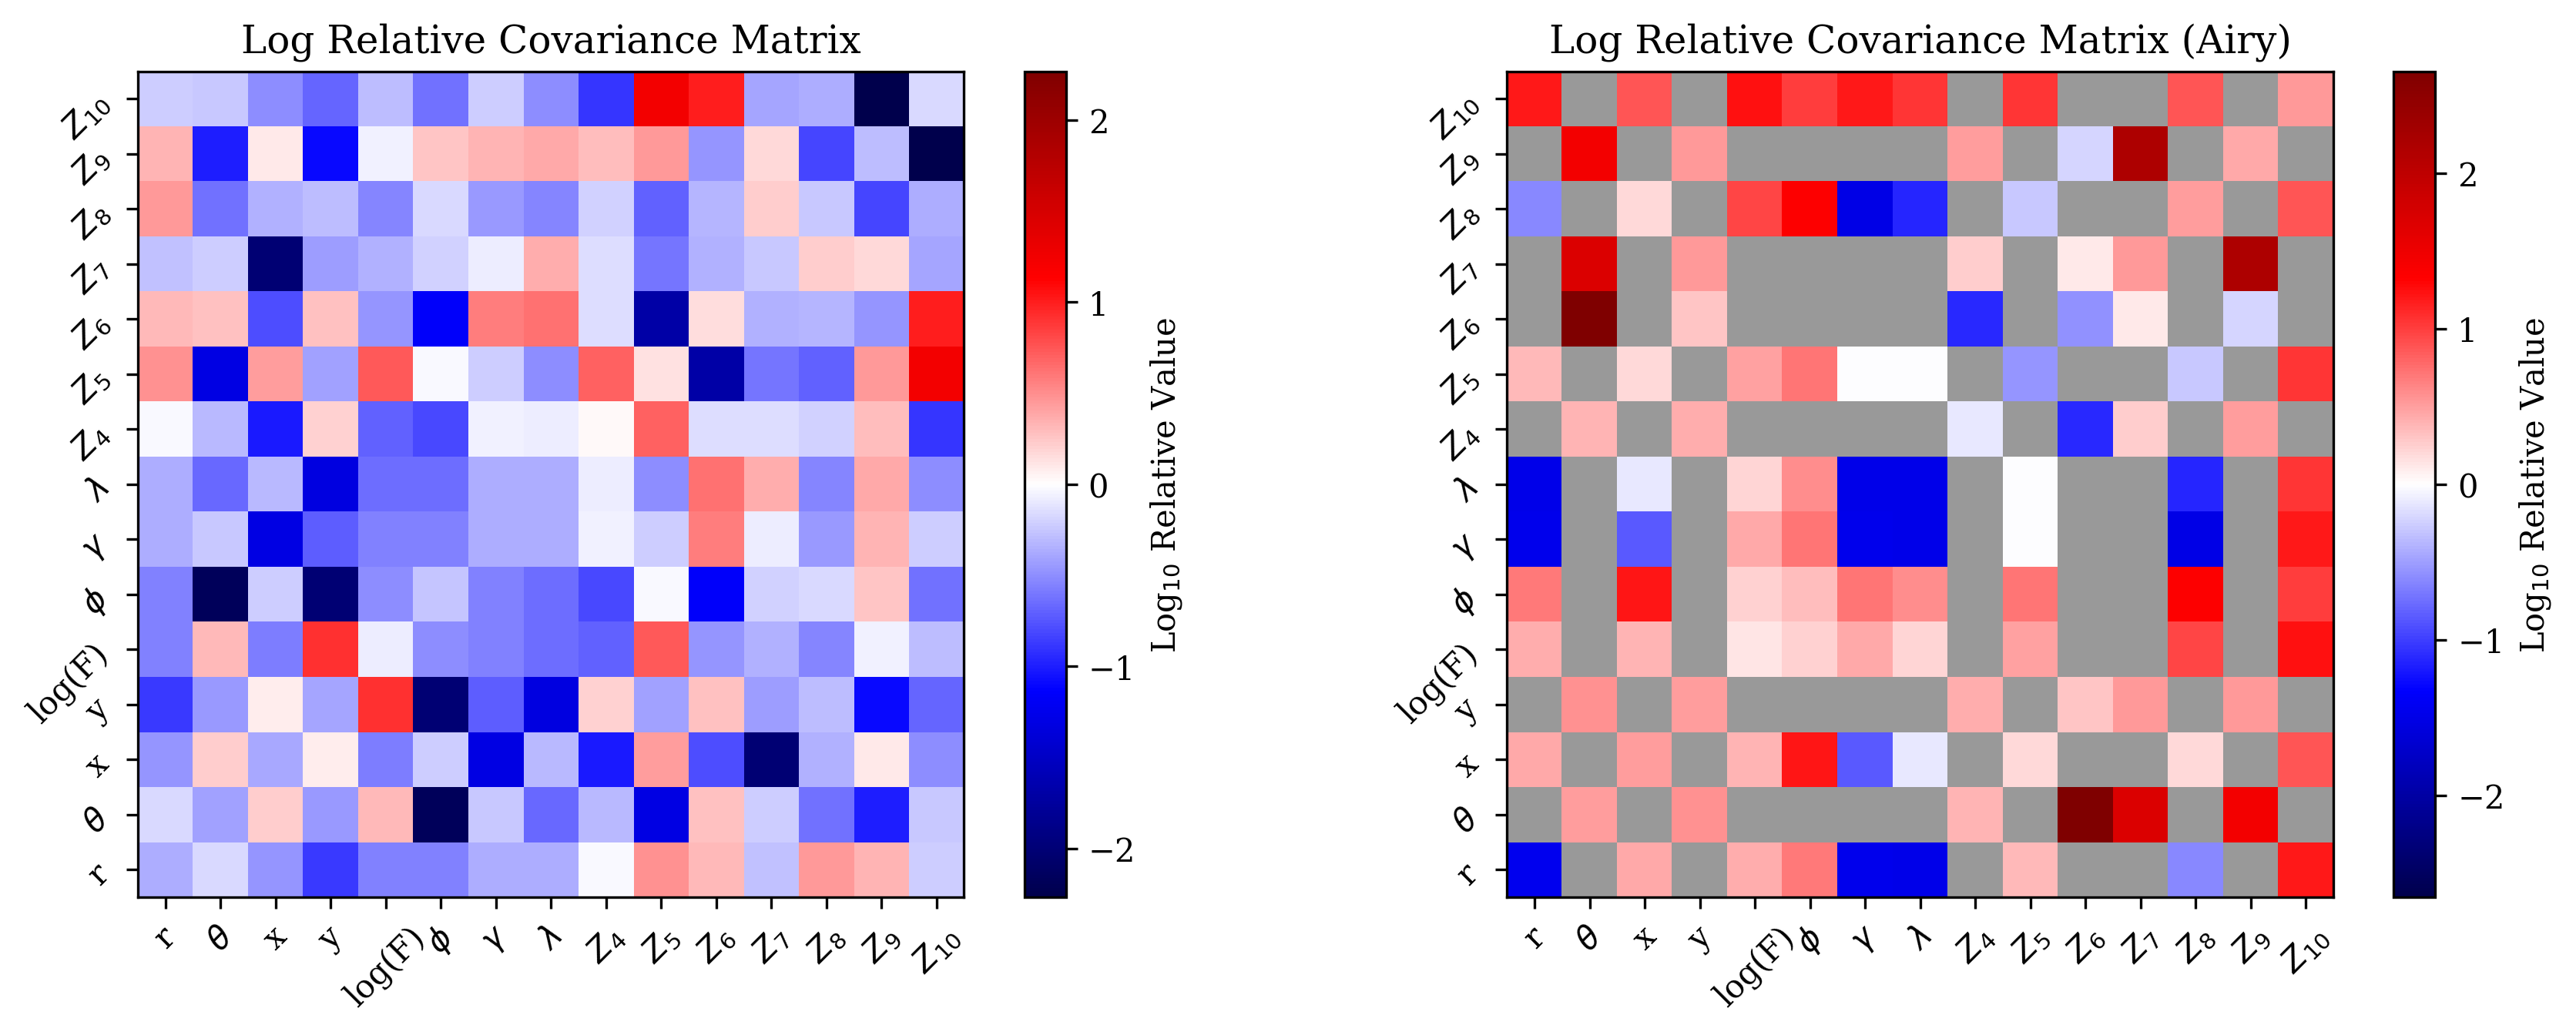

In [24]:
log_cov = np.log10(np.abs(opt_cov / cov))
v = np.max(np.abs(log_cov))

plt.figure(figsize=(12, 4.5))
plt.subplot(1, 2, 1)
plt.title("Log Relative Covariance Matrix")
plt.imshow(log_cov, vmin=-v, vmax=v, cmap='seismic')
plt.xticks(np.arange(len(plot_names)), plot_names, rotation=45)
plt.yticks(np.arange(len(plot_names)), plot_names, rotation=45)
plt.colorbar(label='Log$_{10}$ Relative Value')

# Set all values where the airy disk covmat has a value less than 1e-13 to nan
log_cov = np.log10(np.abs(opt_cov / airy_cov))
log_cov = np.where(np.abs(airy_cov) < 1e-13, np.nan, log_cov)
v = np.nanmax(np.abs(log_cov))

# Nan colormap
nan_seismic = colormaps['seismic']
nan_seismic.set_bad('k', .4)

plt.subplot(1, 2, 2)
plt.title("Log Relative Covariance Matrix (Airy)")
plt.imshow(log_cov, vmin=-v, vmax=v, cmap=nan_seismic)
plt.xticks(np.arange(len(plot_names)), plot_names, rotation=45)
plt.yticks(np.arange(len(plot_names)), plot_names, rotation=45)
plt.colorbar(label='Log$_{10}$ Relative Value')


plt.tight_layout()
plt.savefig("figures/relative_covariance_nan.pdf", dpi=300)
plt.show()

Now lets examine the corner plot of the posteriors. Note that we intentionally don't show the zernike aberrations, as the figure becomes too large to interpret visually.

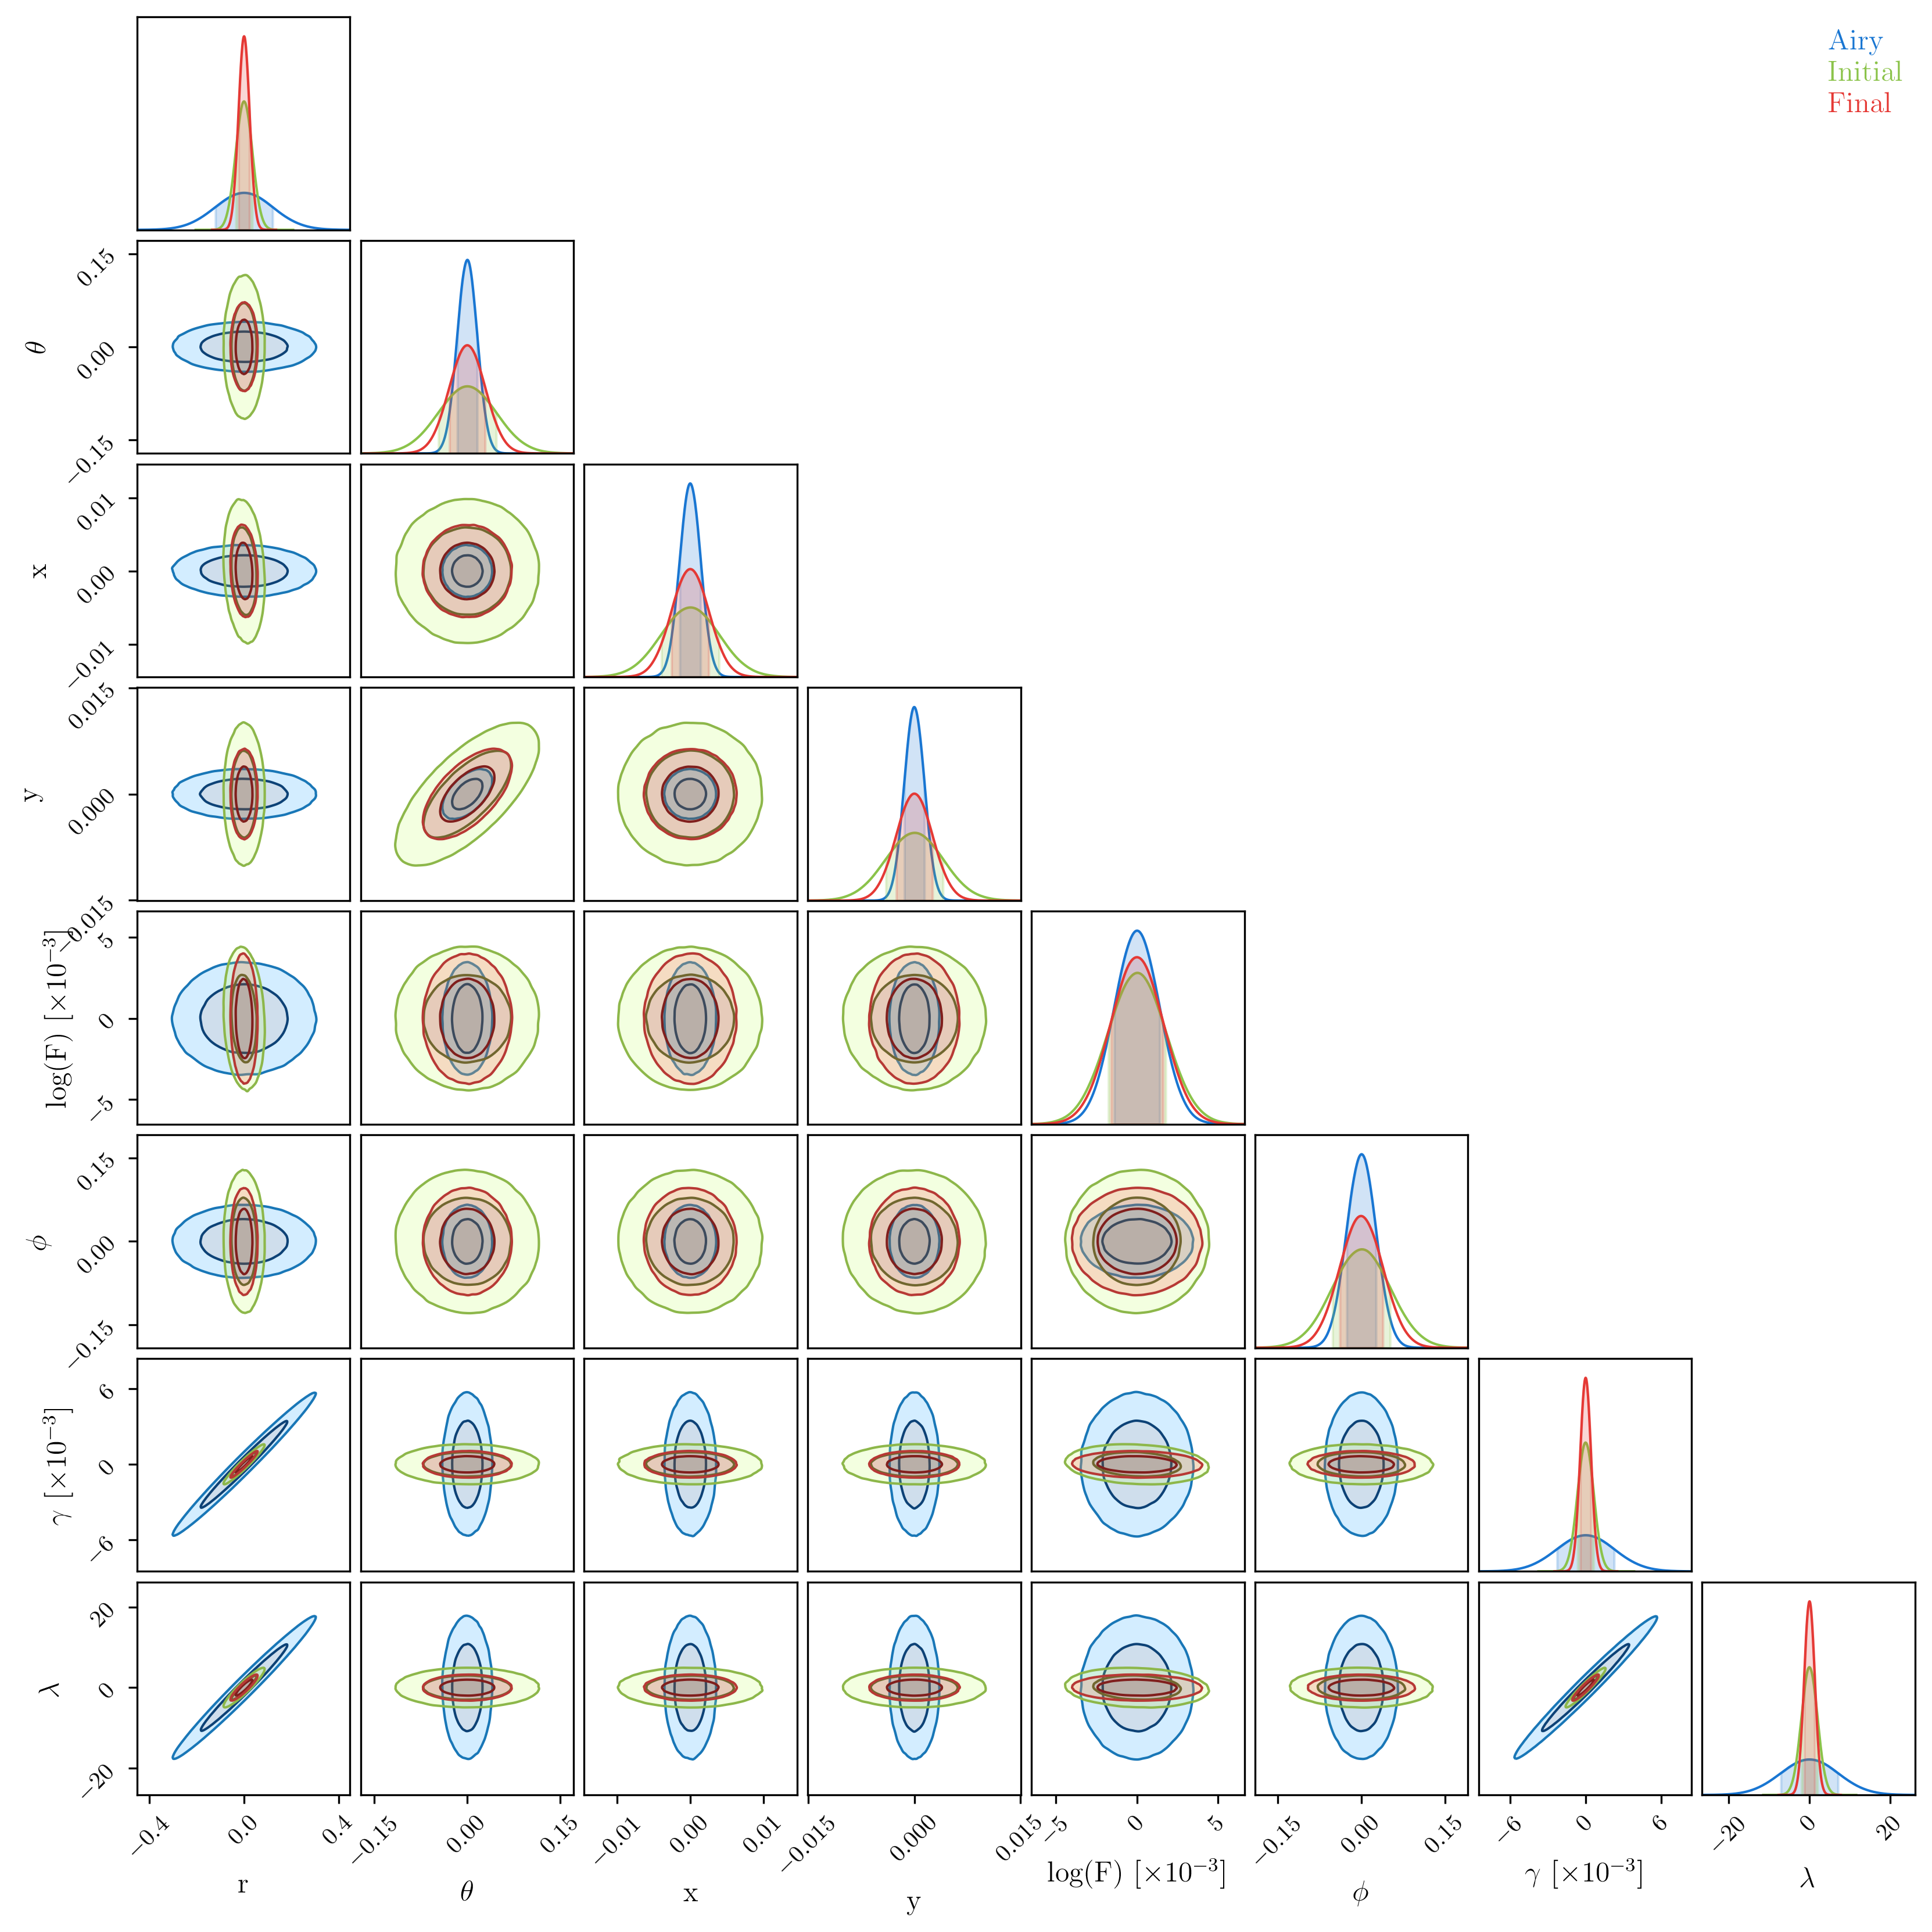

In [25]:
small_cov = cov[:8, :8]
small_opt_cov = opt_cov[:8, :8]
small_airy_cov = airy_cov[:8, :8]
small_names = plot_names[:8]

X = np.zeros(len(small_names))
c = cc.ChainConsumer()
c.add_covariance(X, small_airy_cov, parameters=small_names, name="Airy")
c.add_covariance(X, small_cov, parameters=small_names, name="Initial")
c.add_covariance(X, small_opt_cov, parameters=small_names, name="Final")
c.configure(
    serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1.0, max_ticks=3
)

fig = c.plotter.plot()
# fig.tight_layout()
fig.savefig("figures/posteriors_reduced.pdf", dpi=300)

**The code below is just some fancy plotting for the paper figures**

In [26]:
names = [
    'r', 
    r'$\theta$',
    'x', 
    'y', 
    'log(F)', 
    r'$\phi$', 
    r'$\gamma$', 
    r'$\lambda$', 
    "Z_4",
    "Z_5",
    "Z_6",
    "Z_7",
    "Z_8",
    "Z_9",
    "Z_{10}",]

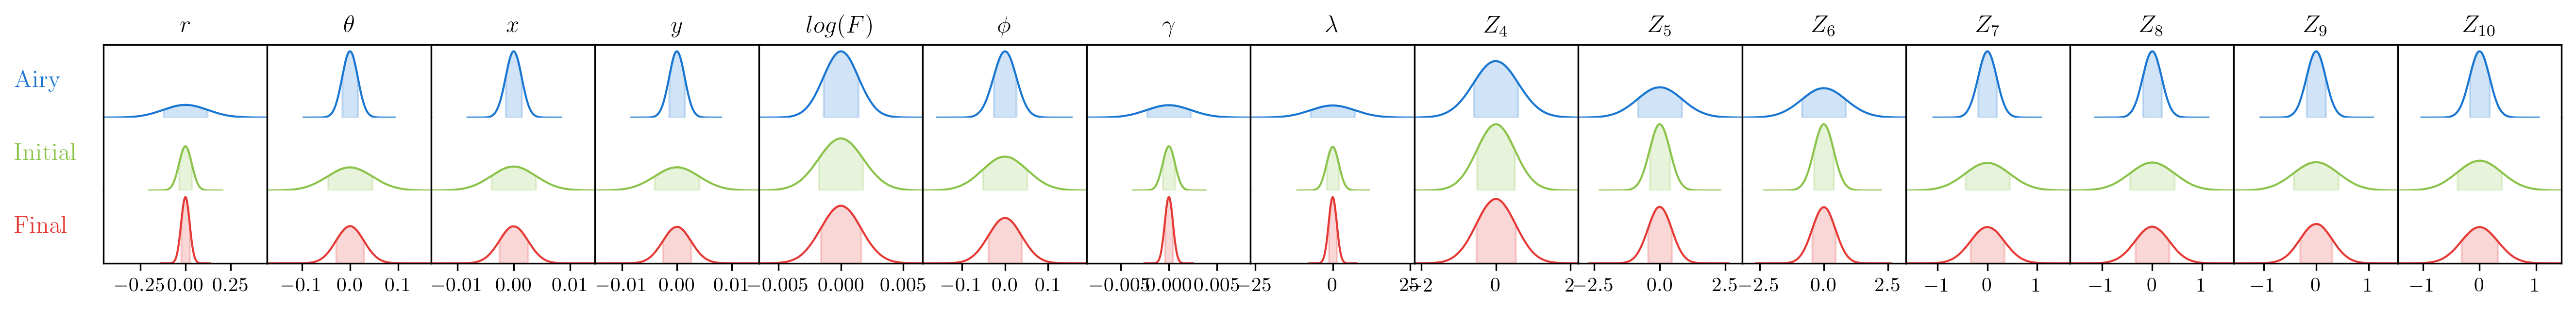

In [27]:
X = np.zeros(len(names))
c = cc.ChainConsumer()
c.add_covariance(X, airy_cov, parameters=names, name="Airy")
c.add_covariance(X, cov, parameters=names, name="Initial")
c.add_covariance(X, opt_cov, parameters=names, name="Final")
c.configure(serif=True, max_ticks=3)
fig = c.plotter.plot_summary(figsize=1.0, extra_parameter_spacing=0.75)

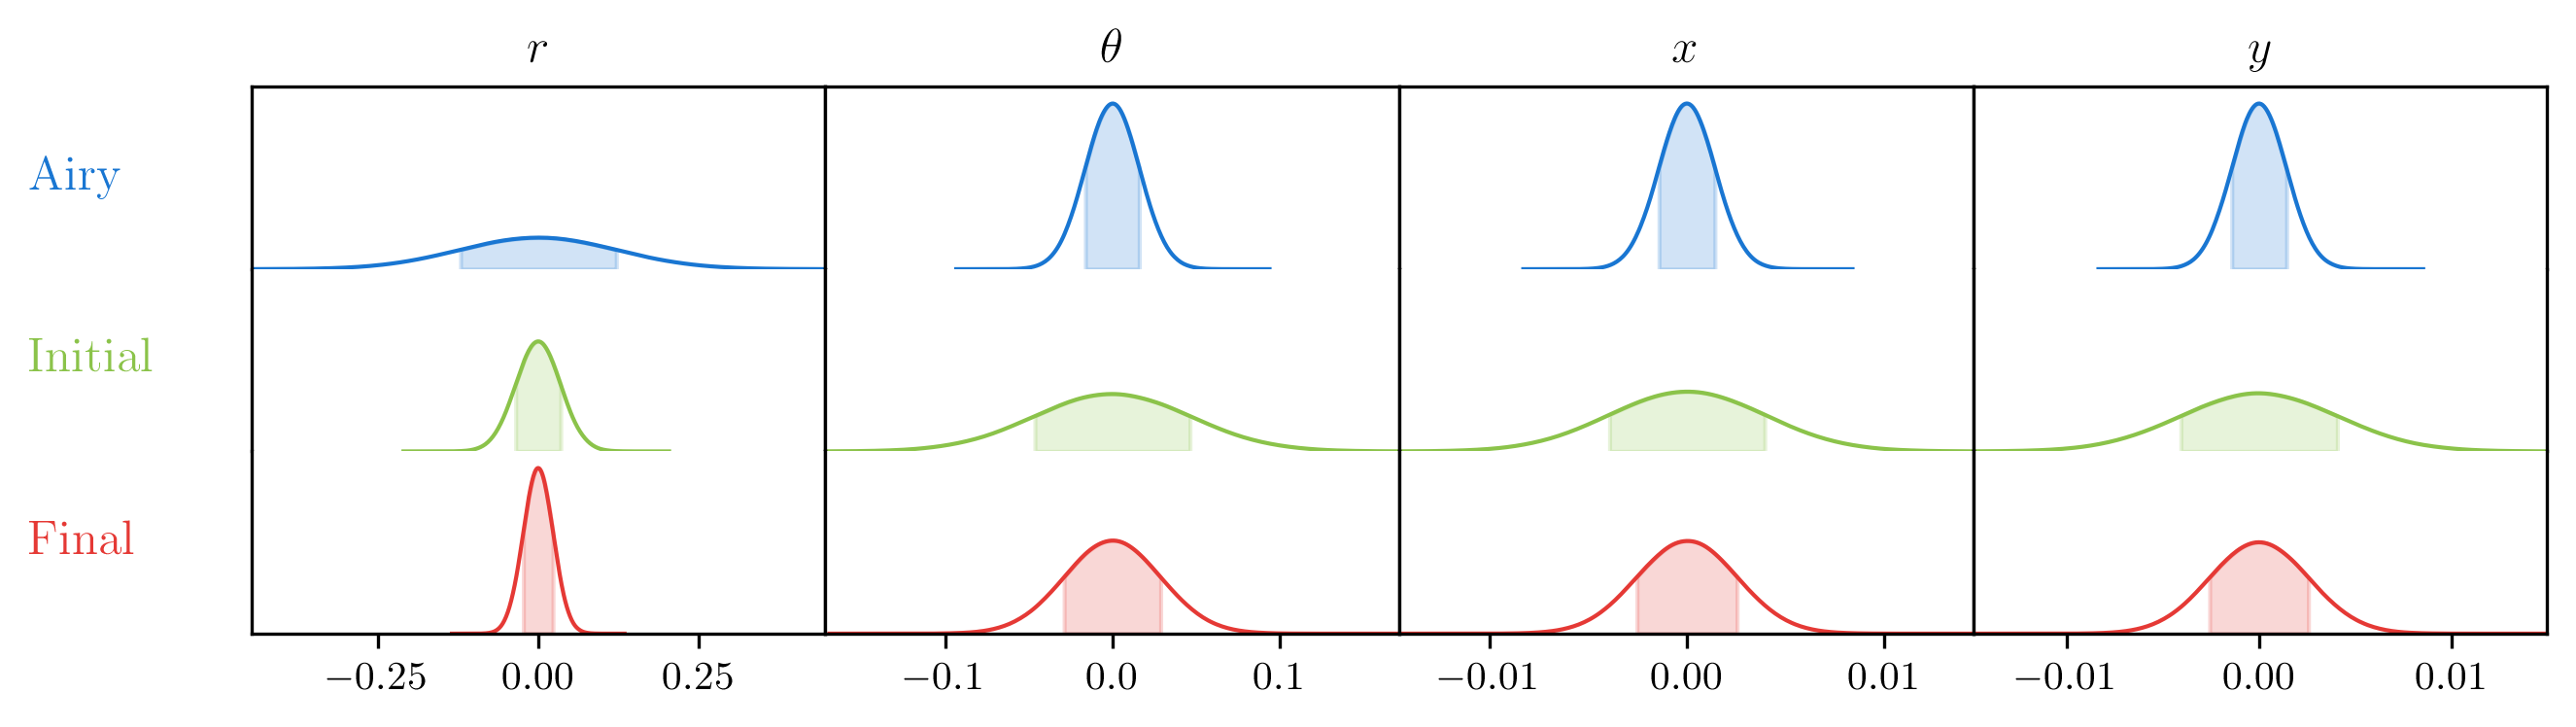

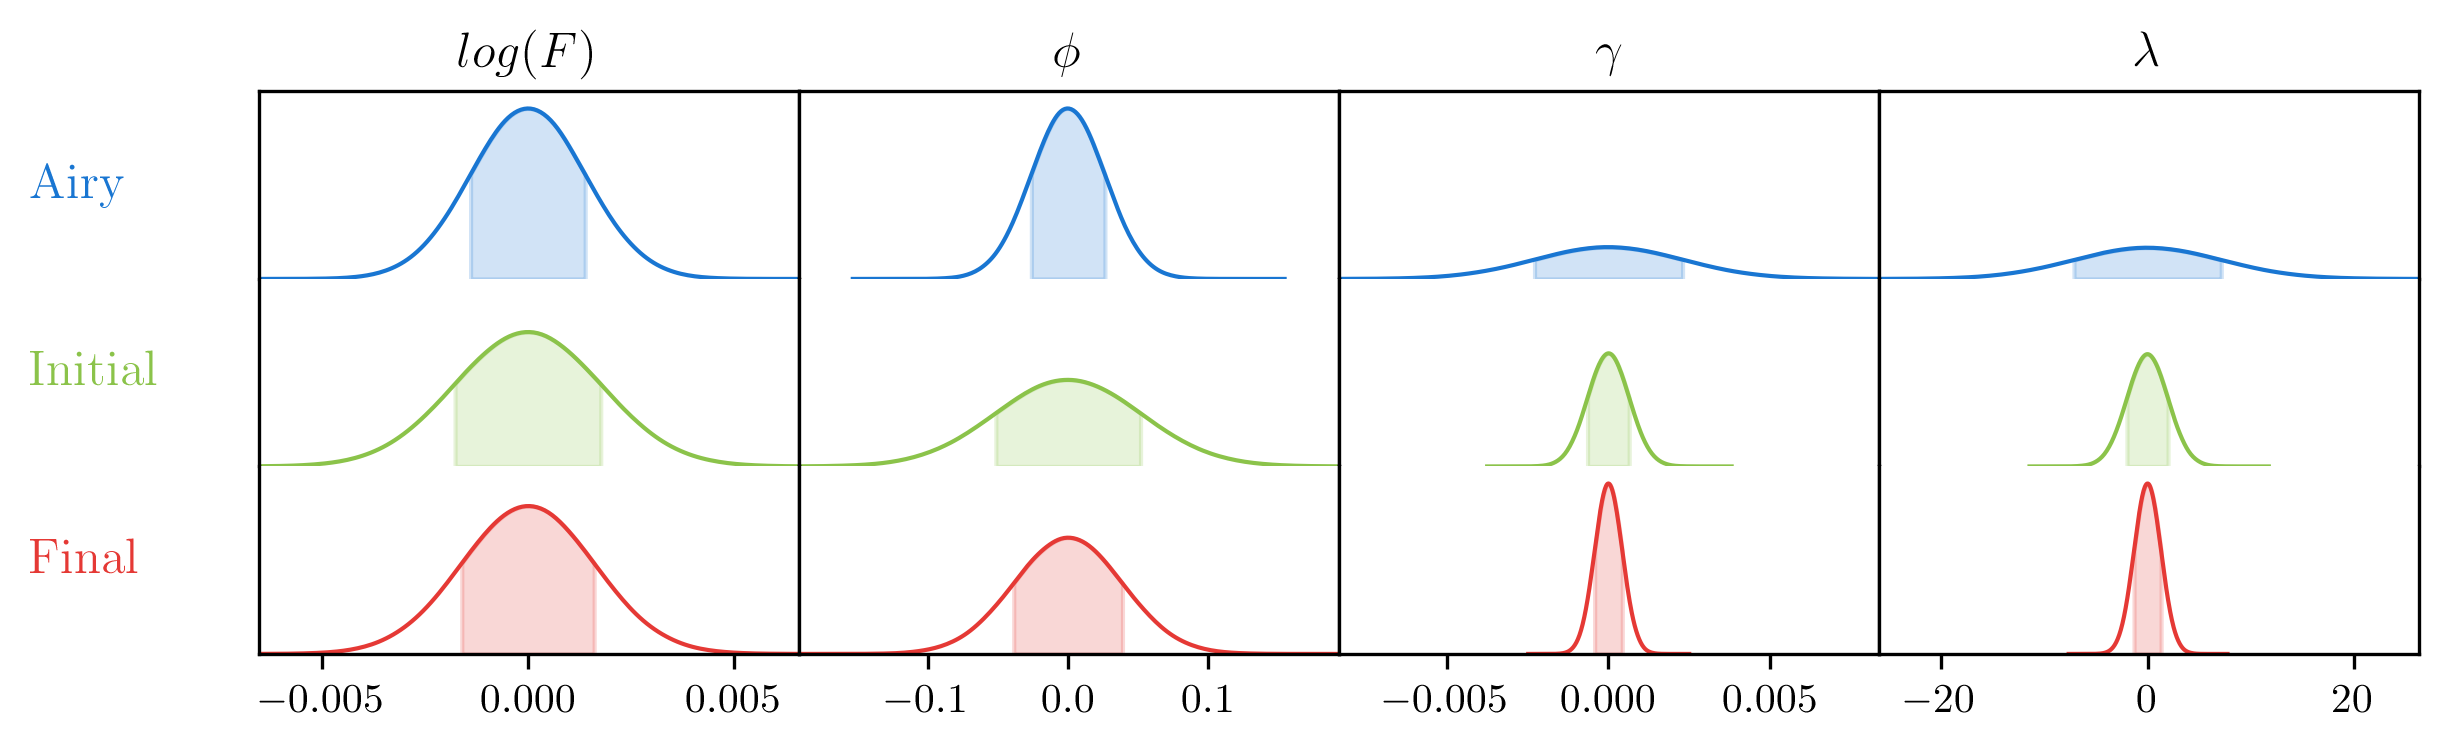

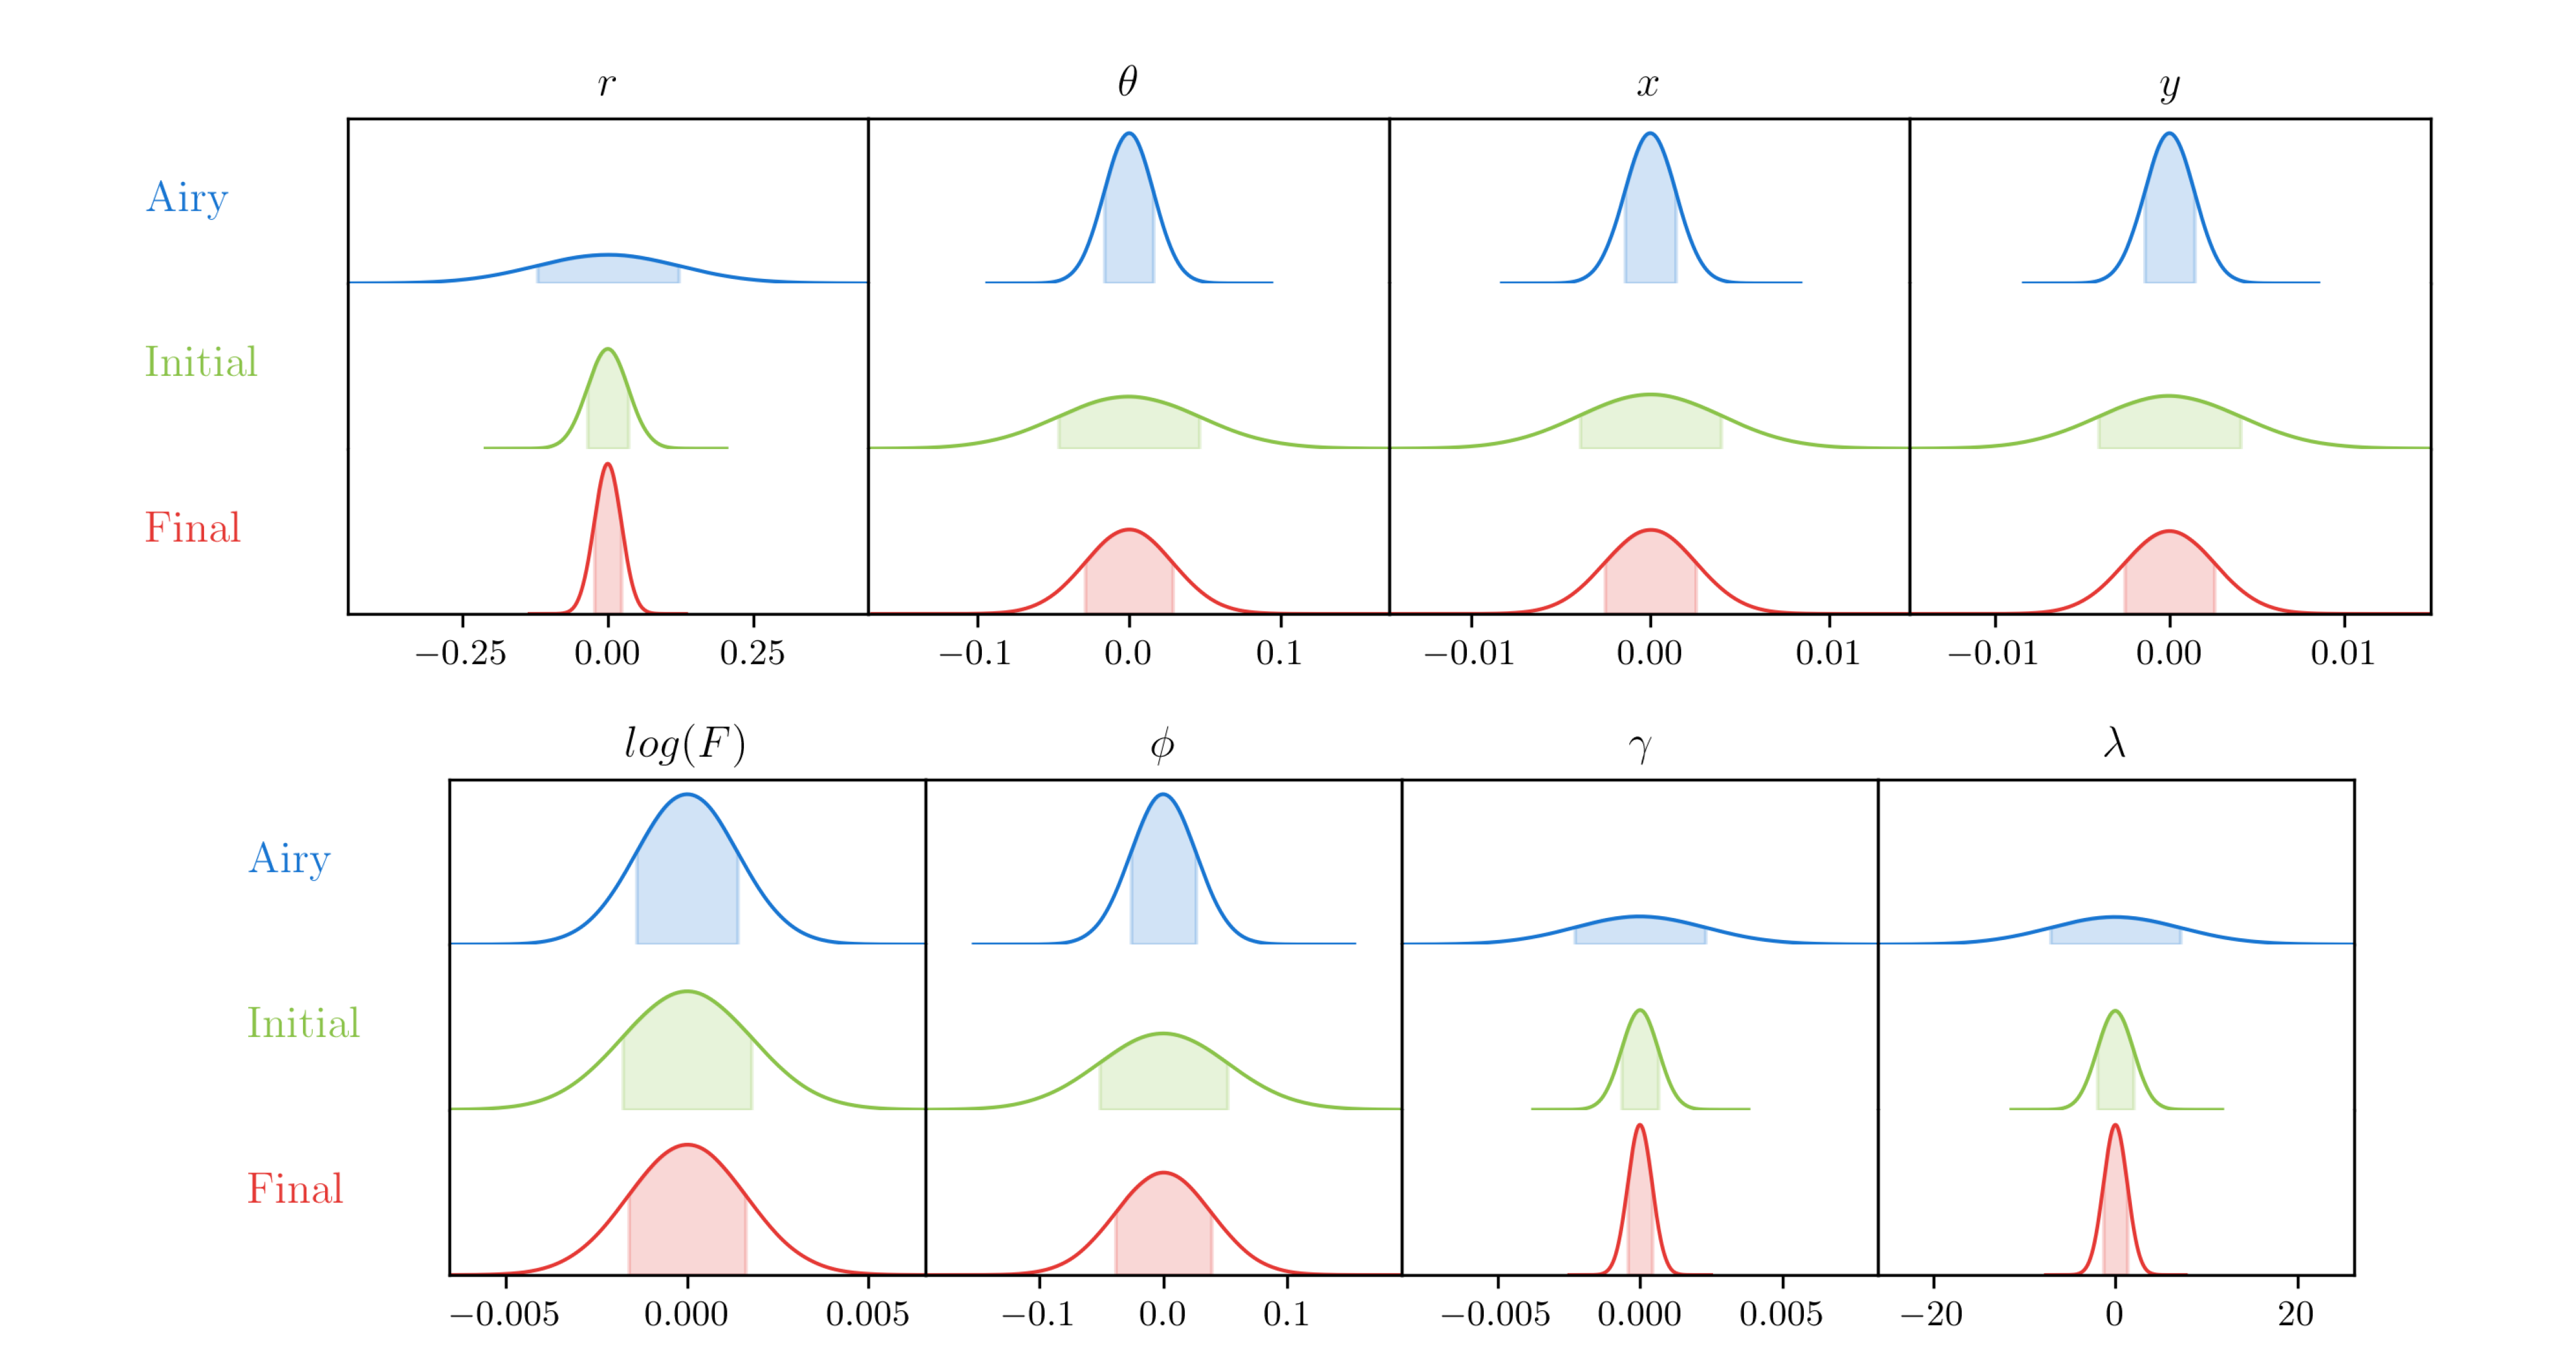

In [28]:
from matplotlib.backends.backend_agg import FigureCanvasAgg

# Split index
k = 4

# Figure 1
small_cov = cov[:k, :k]
small_opt_cov = opt_cov[:k, :k]
small_airy_cov = airy_cov[:k, :k]
small_names = names[:k]

X = np.zeros(len(small_names))
c = cc.ChainConsumer()
c.add_covariance(X, small_airy_cov, parameters=small_names, name='Airy')
c.add_covariance(X, small_cov, parameters=small_names, name='Initial')
c.add_covariance(X, small_opt_cov, parameters=small_names, name='Final')
c.configure(serif=True, max_ticks=3)
fig1 = c.plotter.plot_summary(figsize=1.25, extra_parameter_spacing=1.25)
# fig1.savefig("figures/posteriors_1.pdf", dpi=300)


# Figure 2
small_cov = cov[k:8, k:8]
small_opt_cov = opt_cov[k:8, k:8]
small_airy_cov = airy_cov[k:8, k:8]
small_names = names[k:8]

X = np.zeros(len(small_names))
c = cc.ChainConsumer()
c.add_covariance(X, small_airy_cov, parameters=small_names, name='Airy')
c.add_covariance(X, small_cov, parameters=small_names, name='Initial')
c.add_covariance(X, small_opt_cov, parameters=small_names, name='Final')
c.configure(serif=True, max_ticks=3)
fig2 = c.plotter.plot_summary(figsize=1.25, extra_parameter_spacing=1.1)
# fig2.savefig("figures/posteriors_2.pdf")


# create a new figure and add the subplots from the two figures
fig_combined = plt.figure(figsize=(14, 7))

# render the first figure as an image and display it as a subplot
canvas1 = FigureCanvasAgg(fig1)
canvas1.draw()
image1 = canvas1.buffer_rgba()

ax_combined1 = fig_combined.add_axes([0, 0.5, 0.99, 0.5])
ax_combined1.imshow(image1, origin='upper')
ax_combined1.set_xticks([])
ax_combined1.set_yticks([])
ax_combined1.axis('off')

# render the second figure as an image and display it as a subplot
canvas2 = FigureCanvasAgg(fig2)
canvas2.draw()
image2 = canvas2.buffer_rgba()
ax_combined2 = fig_combined.add_axes([0, 0, 1.0, 0.5])
ax_combined2.imshow(image2, origin='upper')
ax_combined2.set_xticks([])
ax_combined2.set_yticks([])
ax_combined2.axis('off')

# fig.tight_layout()
fig_combined.savefig("figures/posteriors.pdf", dpi=300)

---

# Optimising multiple models

Now we want to perform the same optimisation on 5 different seeds, and see how the results compare!

In [29]:
import optax
from tqdm.notebook import tqdm

def optimise_mask(model, seed, nepochs=25, lr=5e-1):
    """Optimise the mask coefficients"""
    
    # Initialise
    coefficients = jr.normal(jr.PRNGKey(seed),  model.pupil.coefficients.shape)
    model = model.set('pupil.coefficients', coefficients)
    optim, opt_state = zdx.get_optimiser(model, 'pupil.coefficients', optax.adam(lr))

    losses = []
    with tqdm(range(nepochs), desc='Gradient Descent', leave=False) as t:
        for i in t: 
            loss, grads = loss_fn(model)
            updates, opt_state = optim.update(grads, opt_state)
            model = zdx.apply_updates(model, updates)
            losses.append(loss)

            # t.set_description("Loss: {:.3f}".format(np.log10(loss))) # update the progress bar
            t.set_description("Loss: {:.3f}".format(loss)) # update the progress bar
    return model, losses

In [30]:
seeds = np.arange(5)

losses_out, final_models = [], []
for seed in tqdm(seeds):
    model, losses = optimise_mask(model, seed, nepochs=25, lr=5e-1)
    losses_out.append(losses)
    final_models.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

Gradient Descent:   0%|          | 0/25 [00:00<?, ?it/s]

Gradient Descent:   0%|          | 0/25 [00:00<?, ?it/s]

Gradient Descent:   0%|          | 0/25 [00:00<?, ?it/s]

Gradient Descent:   0%|          | 0/25 [00:00<?, ?it/s]

Gradient Descent:   0%|          | 0/25 [00:00<?, ?it/s]

In [31]:
log_covs = []
for i, model in enumerate(final_models):

    # Caclulate the covariance matrix
    cov = zdx.self_covariance_matrix(model, marginal_params, 
        zdx.poiss_loglike, shape_dict=shape_dict)

    # Calculate the initial covariance matrix
    coefficients = jr.normal(jr.PRNGKey(i),  model.pupil.coefficients.shape)
    init_model = model.set('pupil.coefficients', coefficients)
    initial_cov = zdx.self_covariance_matrix(init_model, marginal_params, 
        zdx.poiss_loglike, shape_dict=shape_dict)

    # Calc logcov
    log_covs.append(np.log10(np.abs(cov/initial_cov)))

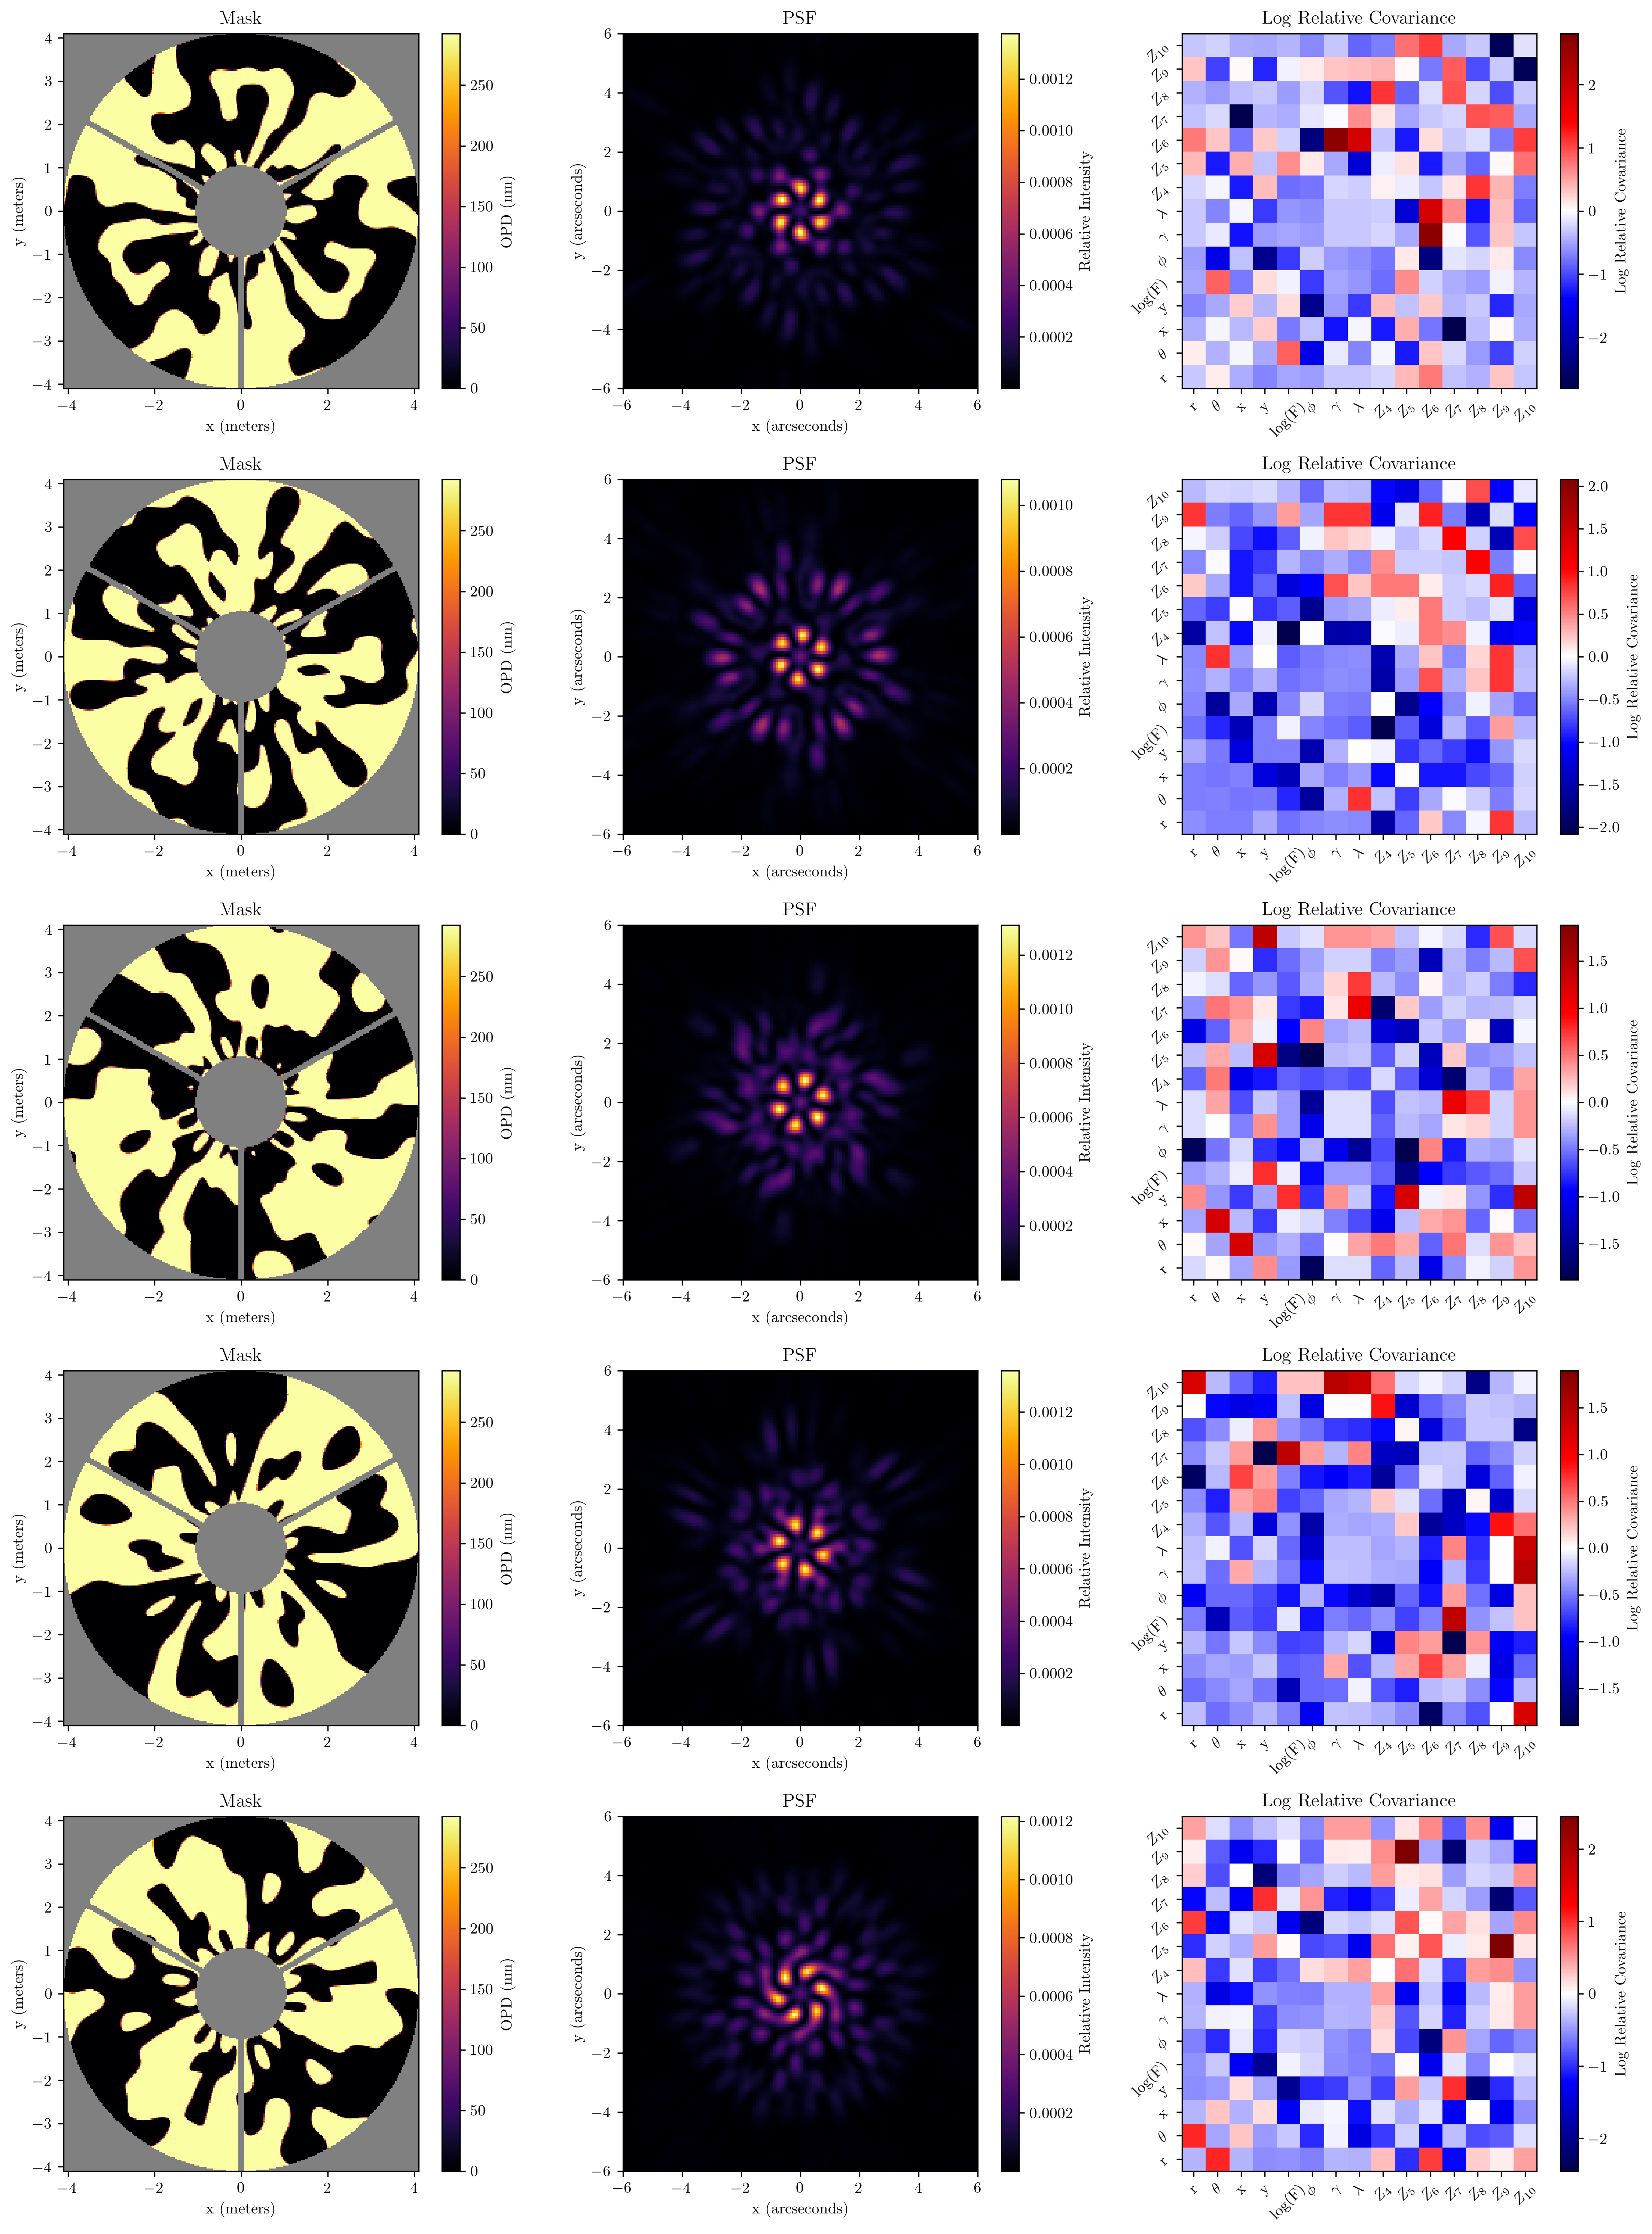

In [32]:
# Support colormap
from matplotlib import colormaps
cmap = colormaps['inferno']
cmap.set_bad('k', .5)

mean_wl = source.wavelengths.mean()
support = tel.aperture.transmission

plt.figure(figsize=(15, 4 * len(final_models)))

# Plot Extents
c, s = model.psf_npixels // 2, 64
aperture_extent = [-diameter/2, diameter/2, -diameter/2, diameter/2]
fov = s * model.psf_pixel_scale
psf_extent = [-fov/2, fov/2, -fov/2, fov/2]

for i, model in enumerate(final_models):

    # Get Masks
    final_mask = model.pupil.get_binary_phase().at[support <= 0.5].set(np.nan)
    final_psf = model.model()
    final_psf = model.propagate(model.source.wavelengths*1e-9)

    # Crop psfs
    final_psf = final_psf[c-s:c+s, c-s:c+s]


    plt.subplot(len(final_models), 3, 3*i + 1)
    plt.imshow(0.5 * mean_wl * final_mask / np.pi, cmap=cmap, extent=aperture_extent)
    plt.title("Mask")
    plt.xlabel("x (meters)")
    plt.ylabel("y (meters)")
    plt.colorbar(label='OPD (nm)')

    plt.subplot(len(final_models), 3, 3*i + 2)
    plt.imshow(final_psf, extent=psf_extent)
    plt.title("PSF")
    plt.xlabel("x (arcseconds)")
    plt.ylabel("y (arcseconds)")
    plt.colorbar(label="Relative Intensity")

    v = np.max(np.abs(log_covs[i]))

    plt.subplot(len(final_models), 3, 3*i + 3)
    plt.title("Log Relative Covariance")
    plt.imshow(log_covs[i], vmin=-v, vmax=v, cmap='seismic')
    plt.xticks(np.arange(len(plot_names)), plot_names, rotation=45)
    plt.yticks(np.arange(len(plot_names)), plot_names, rotation=45)
    plt.colorbar(label='Log Relative Covariance')

plt.tight_layout()
plt.savefig('figures/multi_seeds.pdf')
plt.show()